# Strain Rate Methodology
Started Jan 10 2024 by George Lu

Last modified Jan 11 2024 by George Lu

This Jupyter notebook will be the definitive methodology notebook for englacial strain rate calculations using ApRES data from the Greenland Lakes 2022-2023 field campaign. It will proceed as follows, for each station and season (we start our analysis with winter season data as it is cleanest):
1. Derive clean profile data for each individual burst. We will use our least conservative gain settings because we can then apply our half-chirp filter to neglect clipping. Since if the signal is clipped, changing the gain does not prevent it from happening, but it does hide its immediately noticeable effects.
    1. If clipping effects are observed, only use the latter half of the chirp.
    2. Consider normalizing average amplitude across bursts to remove surface/electronic effects.
2. Once we have our profile series, determine an average strain rate by summing up the total displacement over the season. 
3. Then, determine an optimal window length for leapfrog method. Essentially, calculate strain rate between bursts shifted further apart in the season until they converge to the average strain rate. This method should work better than our previously used summation method as it preserves temporal resolution and also has lower error. 
4. Alter this window surrounding lake drainages if necessary.

# Set up code

In [35]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    16:17:48 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    16:17:48 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    16:17:48 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33617")
client

<Client: 'tcp://127.0.0.1:33617' processes=4 threads=16, memory=125.81 GiB>

# Plot all measurements

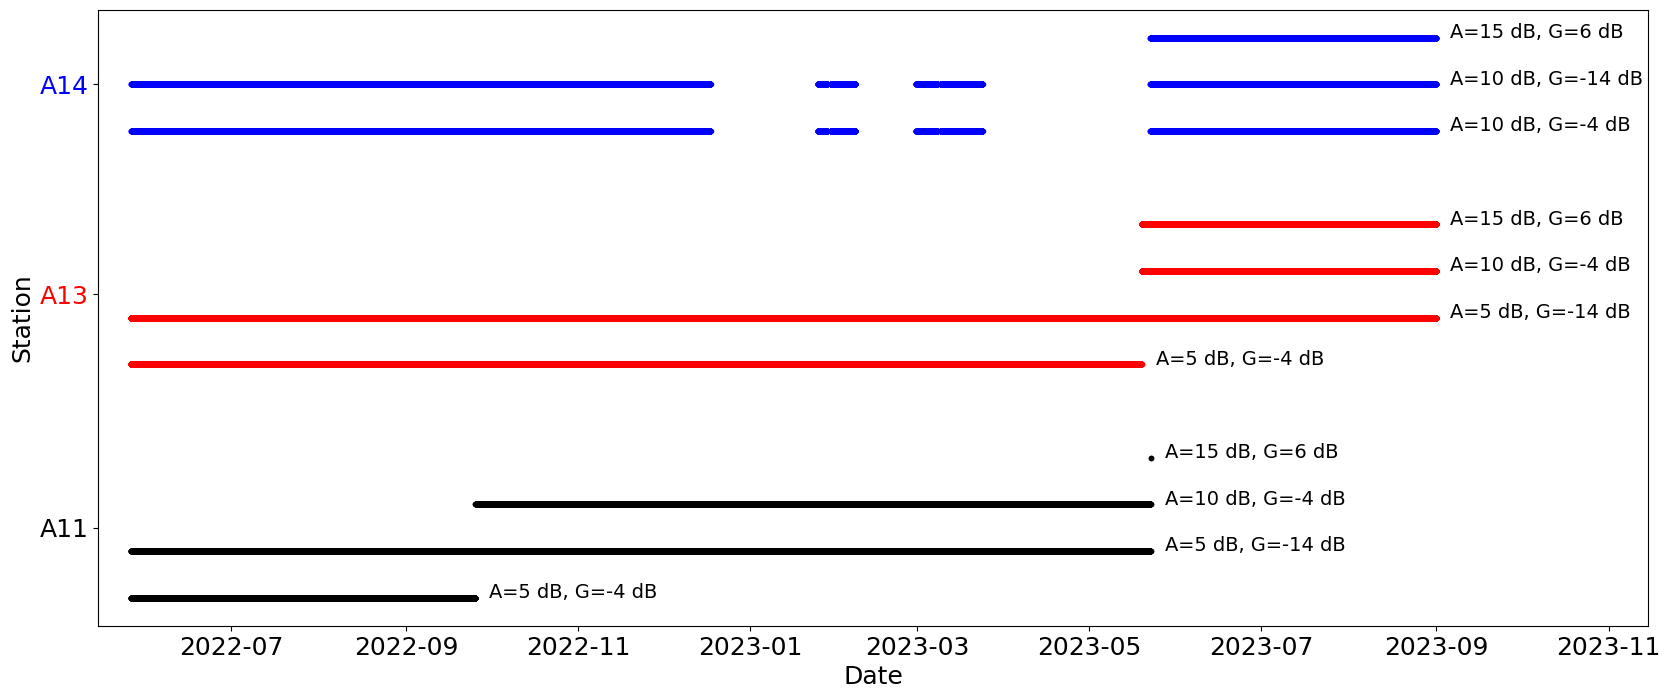

In [4]:
fig, ax = plt.subplots(figsize=(20,8))
anchors = [0,1,2]
a101 = [ds_101,ds_101_w, ds_101_s]
a103 = [ds_103,ds_103_w, ds_103_s]
a104 = [ds_104,ds_104_w, ds_104_s]
site_array = [a101,a103,a104]
site_names = ['A11','A13','A14']
station_colors = ['black','red','blue']
true_anchors = []

for i in anchors:
    station_array = site_array[i]
    setting_count = 0
    setting_pairs = []
    labels = []
    for season in station_array:
        for j in range(len(season.attenuator_setting_pair)):
            pair = (season.attenuator.values[j],season.AFGain.values[j])
            if pair not in setting_pairs:
                setting_pairs.append(pair)
                anchor_point = i + 0.2*setting_count
                setting_count += 1   
                plt.plot(season.time.values,anchor_point*np.ones(season.time.values.shape),linestyle='None',marker='.',color=station_colors[i])
                text = ax.text(season.time.values[-1]+np.timedelta64(5,'D'),anchor_point,f'A={int(pair[0])} dB, G={pair[1]} dB',fontsize=14)
                labels.append(text)
            else:
                anchor_point = i + 0.2*setting_pairs.index(pair)
                plt.plot(season.time.values,anchor_point*np.ones(season.time.values.shape),linestyle='None',marker='.',color=station_colors[i])
                labels[setting_pairs.index(pair)].set_position((season.time.values[-1]+np.timedelta64(5,'D'),anchor_point))

    true_anchors.append(i + 0.1*(setting_count-1))
ax.set_yticks(true_anchors)
ax.set_yticklabels(site_names,fontsize=14)
for ytick, color in zip(ax.get_yticklabels(), station_colors):
    ytick.set_color(color)
plt.xlim([np.datetime64('2022-05-15'), np.datetime64('2023-11-15')])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Station',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)


# Define helper functions
This is to streamline the code

In [7]:
# define function
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

# Station A11

## Winter 2022-2023
We will use settings A = 10 dB and G = -4 dB

In [5]:
to_plot = ds_101_w.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 22956, profile_range: 6658)>
array([[ 1.06155799e-02+0.00000000e+00j,  4.40950831e-06+9.35005244e-03j,
        -6.30365131e-03+4.71999350e-06j, ...,
         2.28379525e-06-5.04751408e-07j, -2.20321862e-06-2.18208259e-06j,
         6.07039677e-06-2.58502522e-06j],
       [ 1.06032189e-02+0.00000000e+00j,  9.55612285e-06+9.34236374e-03j,
        -6.30428694e-03+7.82434236e-06j, ...,
         7.16780930e-06-5.85136580e-06j,  5.39498104e-06+8.33708840e-06j,
        -9.15188298e-06+4.44964330e-06j],
       [ 1.06072221e-02+0.00000000e+00j,  2.18712181e-05+9.35629798e-03j,
        -6.34048535e-03+2.51163593e-05j, ...,
         5.49882332e-07-5.09102075e-06j,  4.93319378e-06+8.92188559e-07j,
        -1.83328135e-06+3.95056138e-06j],
       ...,
       [ 1.05856116e-02+0.00000000e+00j,  7.71162382e-06+9.32832327e-03j,
        -6.30549143e-03+1.54140183e-05j, ...,
        -1.26195549e-06-3.37637842e-06j,  3.90827760e-06+2.24720067e-07j,
        -2.19971420e-06+2.52605882e-06j],
       [ 1.05802997e-02+0.00000000e+00j,  7.97135856e-06+9.32365618e-03j,
        -6.30238432e-03+1.58166440e-05j, ...,
        -3.54655523e-07-1.34851027e-06j,  3.56401689e-06+3.29373087e-07j,
        -2.17010393e-06+4.27161526e-06j],
       [ 1.05839879e-02+0.00000000e+00j,  7.76490620e-06+9.32684984e-03j,
        -6.30443640e-03+1.55134541e-05j, ...,
         2.01931501e-06-2.35314612e-06j,  2.52795123e-06+3.01144527e-06j,
        -3.79231508e-06+1.55249383e-06j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 10.0
    burst_number   (time) int64 0 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49 50
    filename       (time) <U89 'ldeo-glaciology/GL_apres_2022/A101/winter22_2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-09-25T15:29:31 ... 2023-05-22T1...

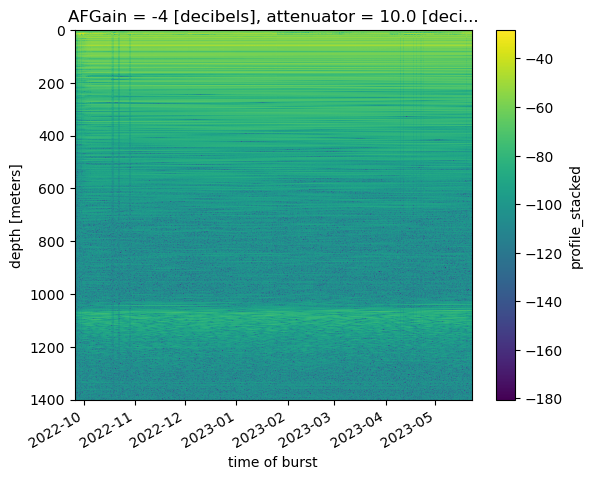

In [6]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

Doesn't look like there's clipping so we proceed.

### Strain Rates

INFO     15:48:04 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [299. 877. 901. ... 901. 900. 901.]s
INFO     15:49:21 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [299. 877. 901. ... 901. 900. 901.]s
INFO     15:50:41 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [299. 877. 901. ... 901. 900. 901.]s
INFO     15:52:07 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [299. 877. 901. ... 901. 900. 901.]s


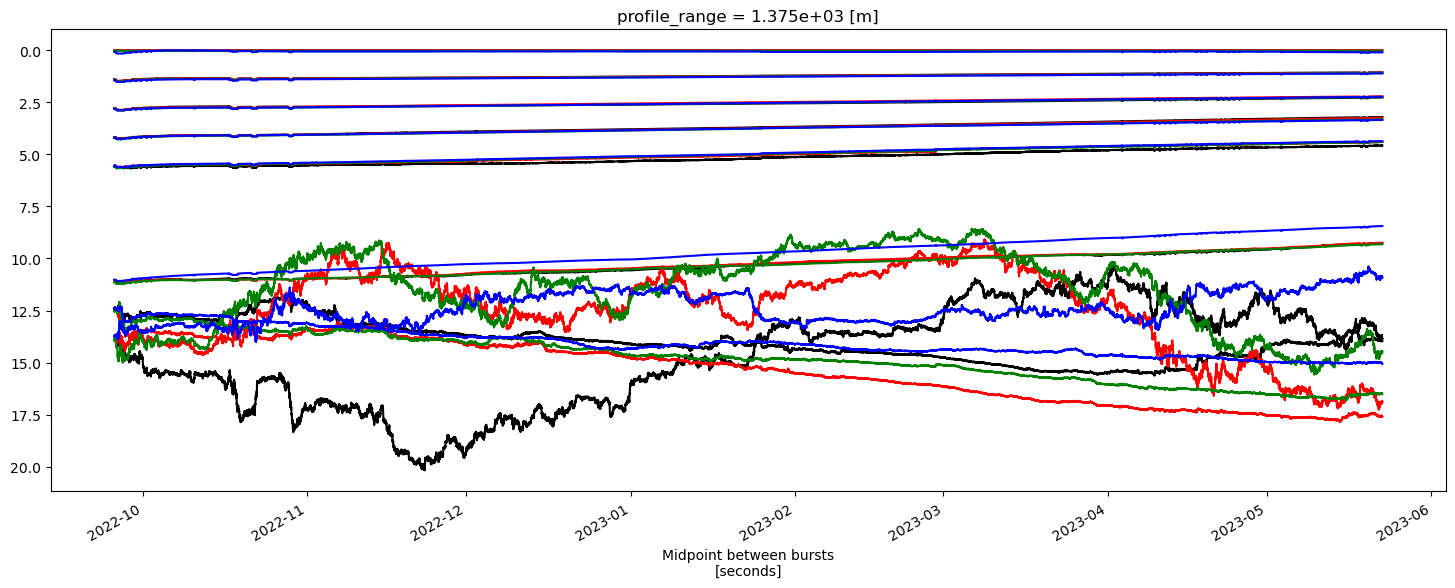

In [7]:
fig, ax = plt.subplots(figsize=(18,6))
da_101_stacked = to_plot
b1= da_101_stacked.isel(time=range(0,len(da_101_stacked)-1))
b2 = da_101_stacked.isel(time=range(1,len(da_101_stacked)))
coherence_windows = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,coherence_windows[i],10,None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     15:53:45 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [299. 877. 901. ... 901. 900. 901.]s
INFO     15:55:22 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [299. 877. 901. ... 901. 900. 901.]s
INFO     15:56:09 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [299. 877. 901. ... 901. 900. 901.]s
INFO     15:56:33 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [299. 877. 901. ... 901. 900. 901.]s


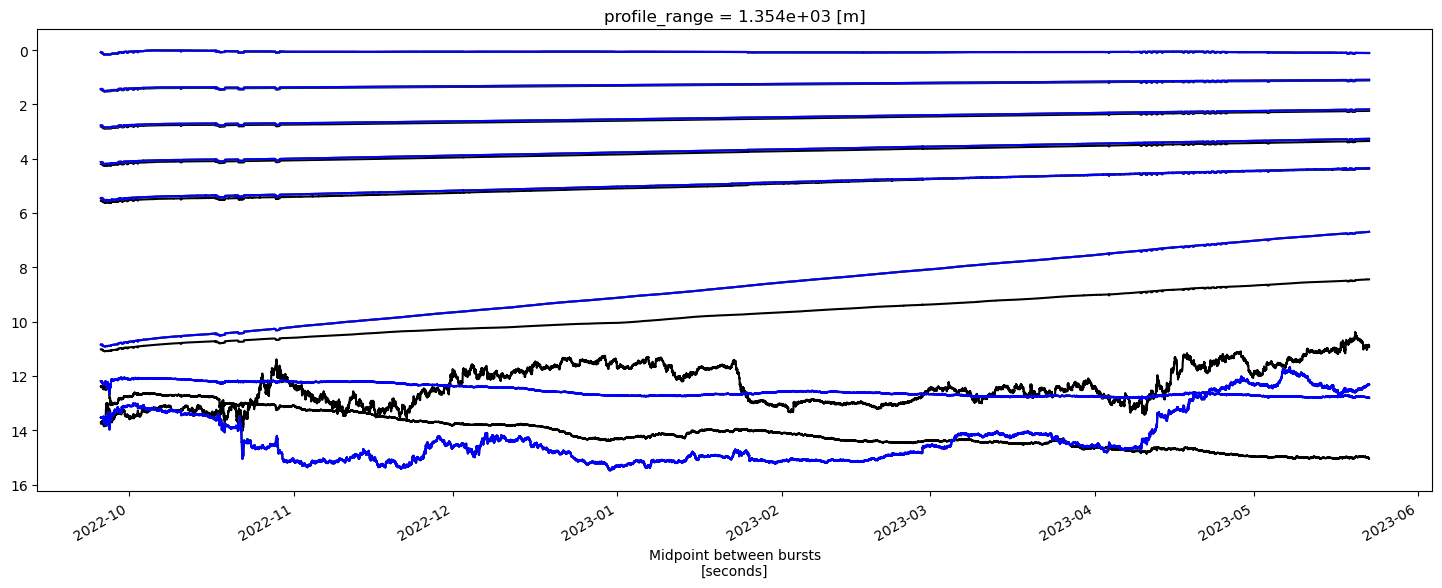

In [8]:
fig, ax = plt.subplots(figsize=(18,6))
da_101_stacked = to_plot
b1= da_101_stacked.isel(time=range(0,len(da_101_stacked)-1))
b2 = da_101_stacked.isel(time=range(1,len(da_101_stacked)))
coherence_steps = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,coherence_steps[i],None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


In this case nothing really changes in the top 500 m, so we continue with strain rates.

INFO     15:56:47 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [299. 877. 901. ... 901. 900. 901.]s
INFO     15:57:32 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [8380. 8969. 9009. ... 8999. 9001. 8968.]s
INFO     15:58:17 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [89368. 89969. 89993. ... 89972. 90005. 90005.]s
INFO     15:59:03 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [449374. 449976. 449997. ... 450011. 450011. 450010.]s


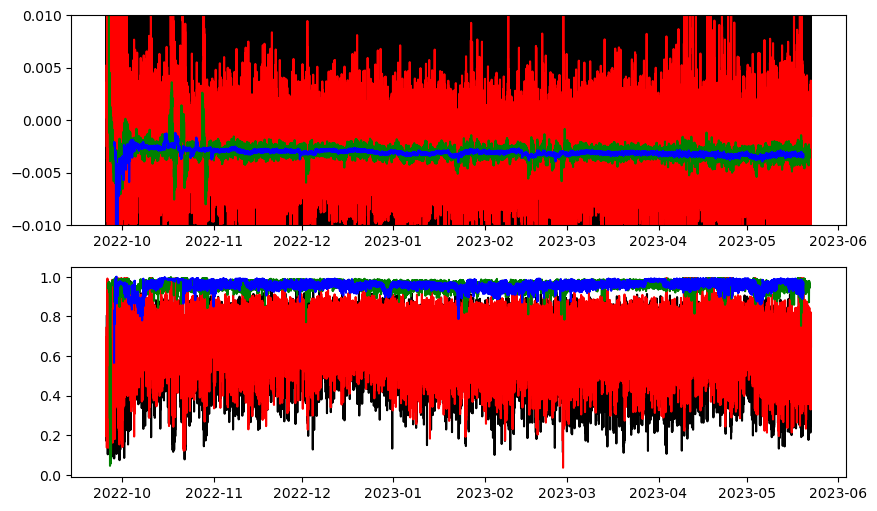

In [9]:
fig, axs = plt.subplots(nrows=2,figsize=(10,6))
da_101_stacked = to_plot

time_windows = [1,10,100,500]
colors = ['k','r','g','b']
for i in range(4):
    b1= da_101_stacked.isel(time=range(0,len(da_101_stacked)-time_windows[i]))
    b2 = da_101_stacked.isel(time=range(time_windows[i],len(da_101_stacked)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,40,20,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95)

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,color=colors[i])
    axs[0].set_ylim([-1e-2,1e-2])
    axs[1].plot(fit.time.values,r2.values,color=colors[i])


In [27]:
del to_plot

## Summer 2022
### Profiles
We will use settings A= 5dB and G = -4 dB.

In [10]:
to_plot = ds_101.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 11703, profile_range: 6658)>
array([[ 1.04618385e-02+0.00000000e+00j,  4.26501701e-05+9.23693327e-03j,
        -6.27796425e-03+4.34813737e-05j, ...,
         1.19840332e-05-8.55320893e-06j,  9.51972256e-06+1.49376352e-05j,
        -1.99264496e-05+7.62303980e-06j],
       [ 1.04713755e-02+0.00000000e+00j,  3.16996879e-05+9.23876915e-03j,
        -6.26616003e-03+3.56836393e-05j, ...,
         1.24221107e-05-4.38062301e-06j,  3.64861291e-06+1.68034519e-05j,
        -1.85948221e-05+3.34217248e-06j],
       [ 1.04737567e-02+0.00000000e+00j,  2.74290772e-05+9.23850750e-03j,
        -6.26121460e-03+3.21018924e-05j, ...,
         1.22516167e-05-1.86013973e-05j,  1.92774619e-05+1.39392061e-05j,
        -1.68664879e-05+1.85494071e-05j],
       ...,
       [ 1.06564243e-02+0.00000000e+00j,  1.51908274e-05+9.38728904e-03j,
        -6.33305665e-03+2.55492919e-05j, ...,
        -5.23737037e-06-1.52326609e-05j,  1.82422943e-05-4.59996309e-06j,
        -4.47682238e-08+2.01448523e-05j],
       [ 1.06552117e-02+0.00000000e+00j,  1.52172810e-05+9.38625681e-03j,
        -6.33250474e-03+2.55823169e-05j, ...,
        -3.53101608e-06-5.05086022e-06j,  5.85621273e-06-3.96907292e-06j,
         6.55683225e-07+5.17477337e-06j],
       [ 1.06560206e-02+0.00000000e+00j,  1.52961658e-05+9.38692359e-03j,
        -6.33288430e-03+2.57586554e-05j, ...,
         3.65597878e-06-7.35152059e-06j,  1.14461841e-06+2.17295685e-06j,
        -2.11383541e-07-3.47928806e-06j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 5.0
    burst_number   (time) int64 6 7 8 9 10 11 12 13 ... 61 62 63 64 65 66 67 68
    filename       (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-26T17:06:29 ... 2022-09-25T1...

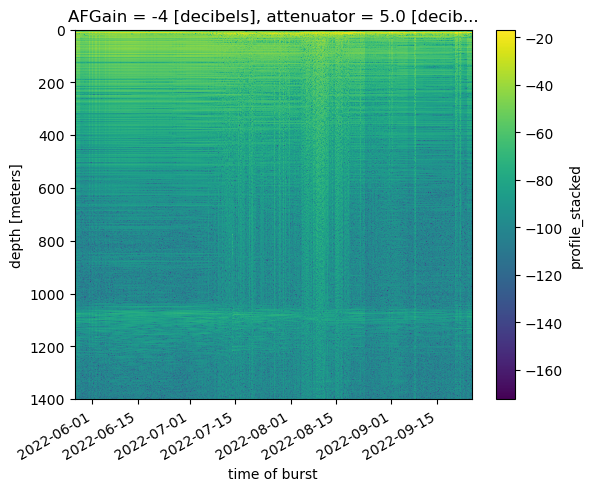

In [11]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

We see from using the full chirp, there is clipping. Consequently, we apply our half chirp. 

In [13]:
da_101_stacked  = custom_stacked_profile_series(ds_101.chirp.isel(attenuator_setting_pair=0),2,3e8,4e8)


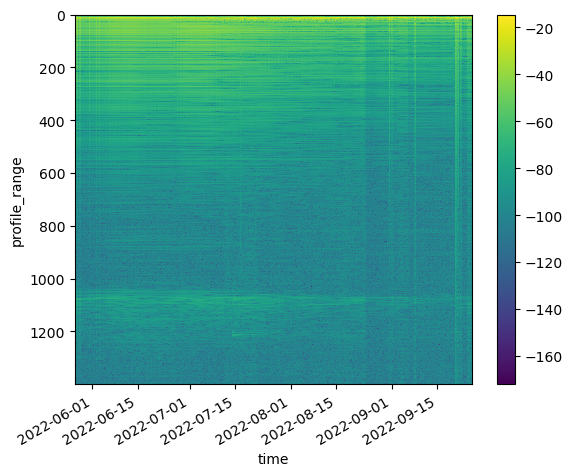

In [14]:
fig, ax = plt.subplots()

xa.dB(da_101_stacked).plot(ax=ax,x='time')
ax.invert_yaxis()

Looks much better.

### Strain rates


INFO     16:05:27 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [901. 900. 900. ... 906. 894. 896.]s
INFO     16:05:47 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [901. 900. 900. ... 906. 894. 896.]s
INFO     16:06:09 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [901. 900. 900. ... 906. 894. 896.]s
INFO     16:06:31 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [901. 900. 900. ... 906. 894. 896.]s


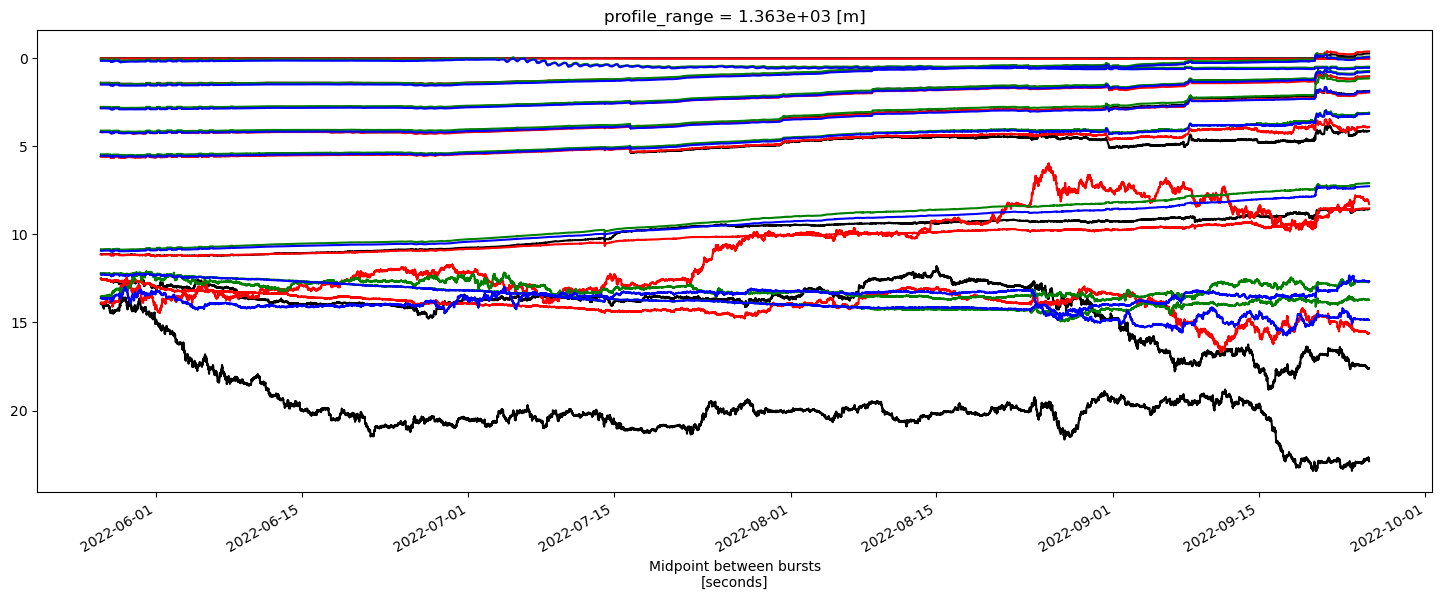

In [15]:
fig, ax = plt.subplots(figsize=(18,6))
b1= da_101_stacked.isel(time=range(0,len(da_101_stacked)-1))
b2 = da_101_stacked.isel(time=range(1,len(da_101_stacked)))
coherence_windows = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,coherence_windows[i],10,None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     16:06:57 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [901. 900. 900. ... 906. 894. 896.]s
INFO     16:07:21 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [901. 900. 900. ... 906. 894. 896.]s
INFO     16:07:34 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [901. 900. 900. ... 906. 894. 896.]s
INFO     16:07:40 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [901. 900. 900. ... 906. 894. 896.]s


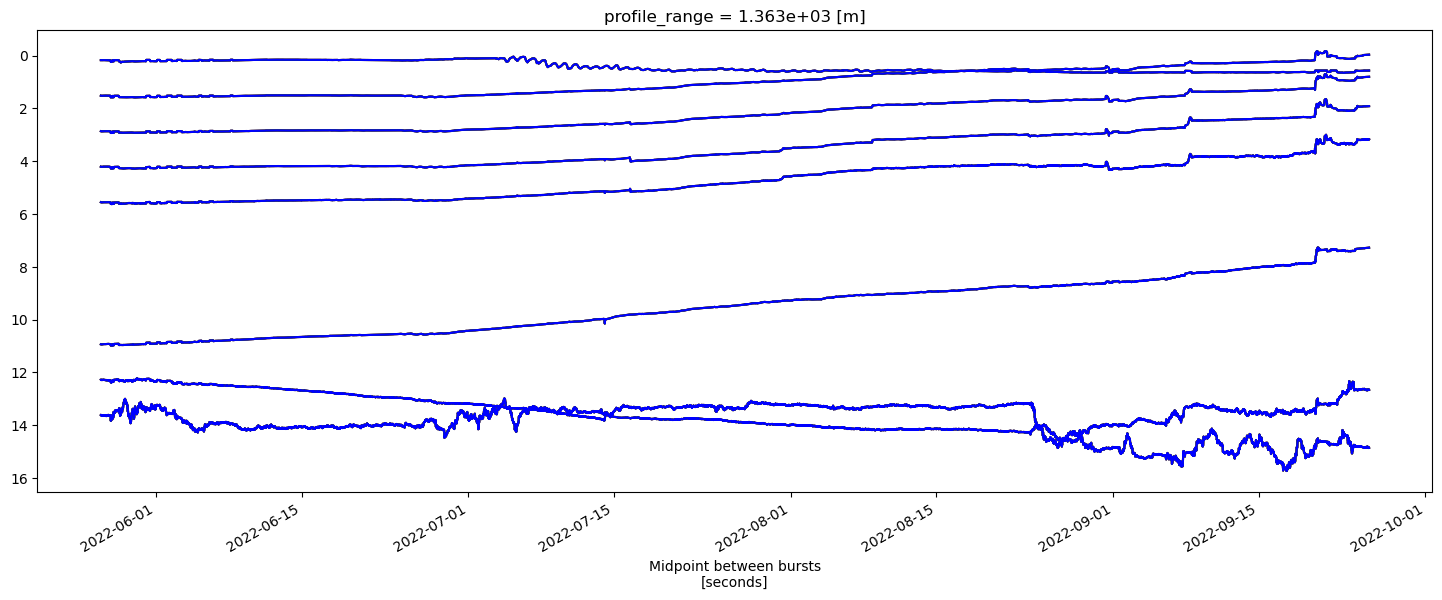

In [16]:
fig, ax = plt.subplots(figsize=(18,6))
b1= da_101_stacked.isel(time=range(0,len(da_101_stacked)-1))
b2 = da_101_stacked.isel(time=range(1,len(da_101_stacked)))
coherence_steps = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,coherence_steps[i],None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     16:07:44 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [901. 900. 900. ... 906. 894. 896.]s
INFO     16:07:56 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [9000. 8999. 9000. ... 9022. 9015. 9012.]s
INFO     16:08:08 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [89998. 89996. 89998. ... 90022. 90016. 90012.]s
INFO     16:08:20 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [450020. 449996. 449996. ... 449751. 449745. 449742.]s


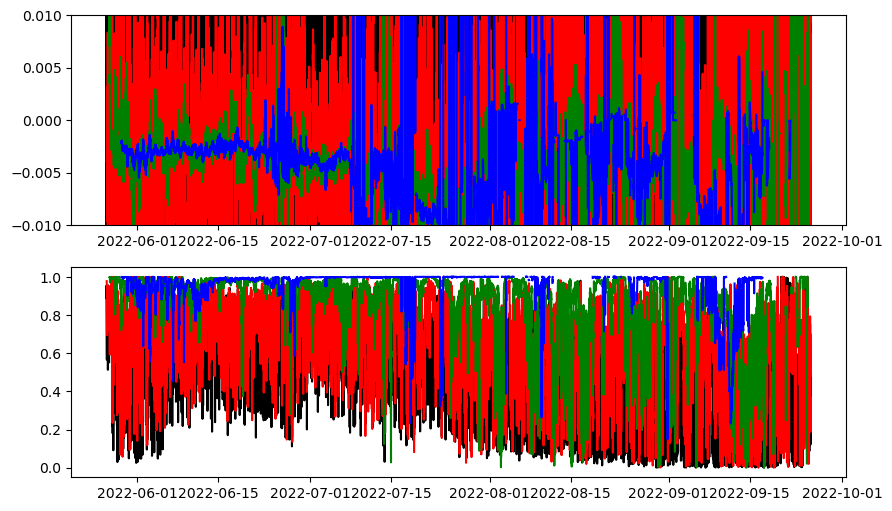

In [17]:
fig, axs = plt.subplots(nrows=2,figsize=(10,6))

time_windows = [1,10,100,500]
colors = ['k','r','g','b']
for i in range(4):
    b1= da_101_stacked.isel(time=range(0,len(da_101_stacked)-time_windows[i]))
    b2 = da_101_stacked.isel(time=range(time_windows[i],len(da_101_stacked)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,40,20,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95)

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,color=colors[i])
    axs[0].set_ylim([-1e-2,1e-2])
    axs[1].plot(fit.time.values,r2.values,color=colors[i])


There is no Summer 2023 data

In [18]:
# clear variable
del da_101_stacked


# Station A13

## Winter 2023
### Profiles
We will use settings A= 5dB and G = -4 dB.

In [22]:
to_plot = ds_103_w.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 22664, profile_range: 6658)>
array([[ 1.03592343e-02+0.00000000e+00j,  1.18348138e-05+9.13083918e-03j,
        -6.17072927e-03+7.44812331e-06j, ...,
        -1.11628441e-05-9.43537972e-05j,  7.49245075e-05-2.28843981e-05j,
         3.47570201e-05+3.67679076e-05j],
       [ 1.03484852e-02+0.00000000e+00j,  1.47345513e-05+9.12041716e-03j,
        -6.16025593e-03+1.65968080e-05j, ...,
         4.57949190e-05-4.22132157e-05j,  5.88205709e-05+2.43345476e-05j,
        -6.33728945e-06+5.48892869e-05j],
       [ 1.03513646e-02+0.00000000e+00j,  3.35703354e-05+9.11926192e-03j,
        -6.14680367e-03+4.90340506e-05j, ...,
        -5.82817517e-05+3.77641508e-05j, -7.39305131e-05-4.06034997e-05j,
         2.30337692e-05-1.02828498e-04j],
       ...,
       [ 1.03002240e-02+0.00000000e+00j,  1.57468426e-05+9.06989083e-03j,
        -6.11415662e-03+2.91432694e-05j, ...,
         2.94532985e-06-8.73865137e-06j,  8.35334035e-06+4.07496622e-06j,
        -3.26159927e-06+7.44086335e-06j],
       [ 1.02996497e-02+0.00000000e+00j,  1.50409352e-05+9.06921168e-03j,
        -6.11309004e-03+2.82384622e-05j, ...,
         1.86338709e-06-9.43442431e-06j,  1.20612655e-05-2.37426891e-07j,
        -3.61954890e-07+1.15440809e-05j],
       [ 1.03060849e-02+0.00000000e+00j,  1.60553570e-05+9.07548009e-03j,
        -6.11903290e-03+2.92516541e-05j, ...,
         6.46431707e-06-6.37062770e-06j,  1.91459244e-06+7.40315937e-06j,
        -5.65634618e-06-3.30352450e-06j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 5.0
    burst_number   (time) int64 0 0 1 2 3 4 5 6 7 ... 14 15 16 17 18 19 20 21 22
    filename       (time) <U89 'ldeo-glaciology/GL_apres_2022/A103/winter22_2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-09-25T12:10:17 ... 2023-05-19T1...

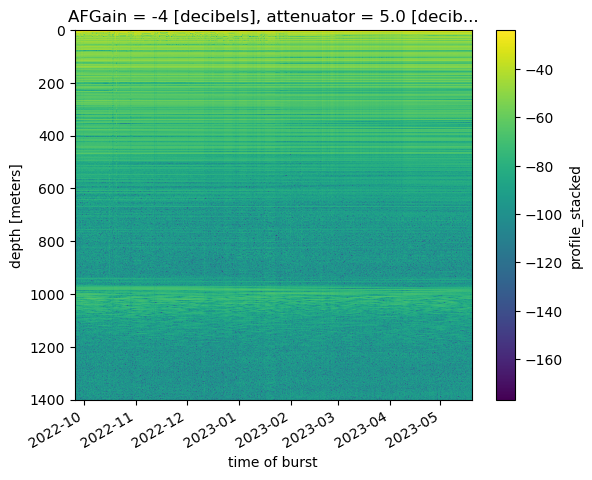

In [23]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

Looks good on its own

### Strain Rates

INFO     16:15:56 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [336. 872. 900. ... 900. 900. 900.]s
INFO     16:17:13 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [336. 872. 900. ... 900. 900. 900.]s
INFO     16:18:33 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [336. 872. 900. ... 900. 900. 900.]s
INFO     16:19:58 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [336. 872. 900. ... 900. 900. 900.]s


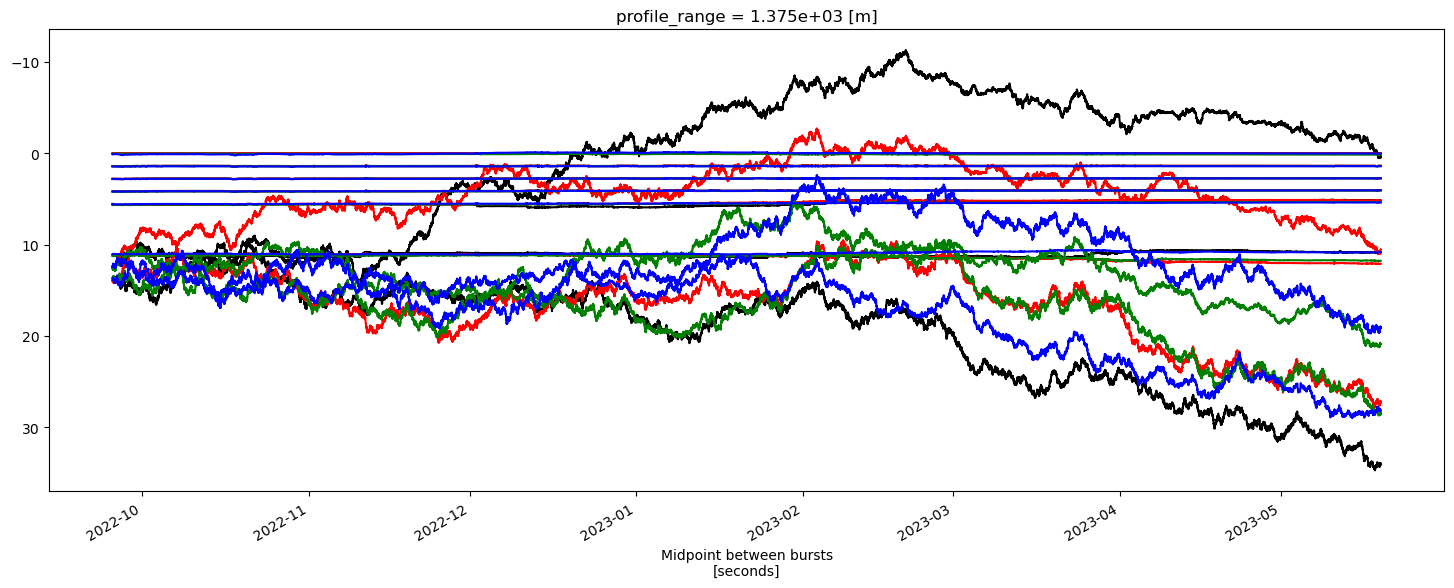

In [24]:
fig, ax = plt.subplots(figsize=(18,6))
da_103_stacked = to_plot
b1= da_103_stacked.isel(time=range(0,len(da_103_stacked)-1))
b2 = da_103_stacked.isel(time=range(1,len(da_103_stacked)))
coherence_windows = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,coherence_windows[i],10,None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     16:21:36 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [336. 872. 900. ... 900. 900. 900.]s
INFO     16:23:12 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [336. 872. 900. ... 900. 900. 900.]s
INFO     16:23:59 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [336. 872. 900. ... 900. 900. 900.]s
INFO     16:24:23 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [336. 872. 900. ... 900. 900. 900.]s


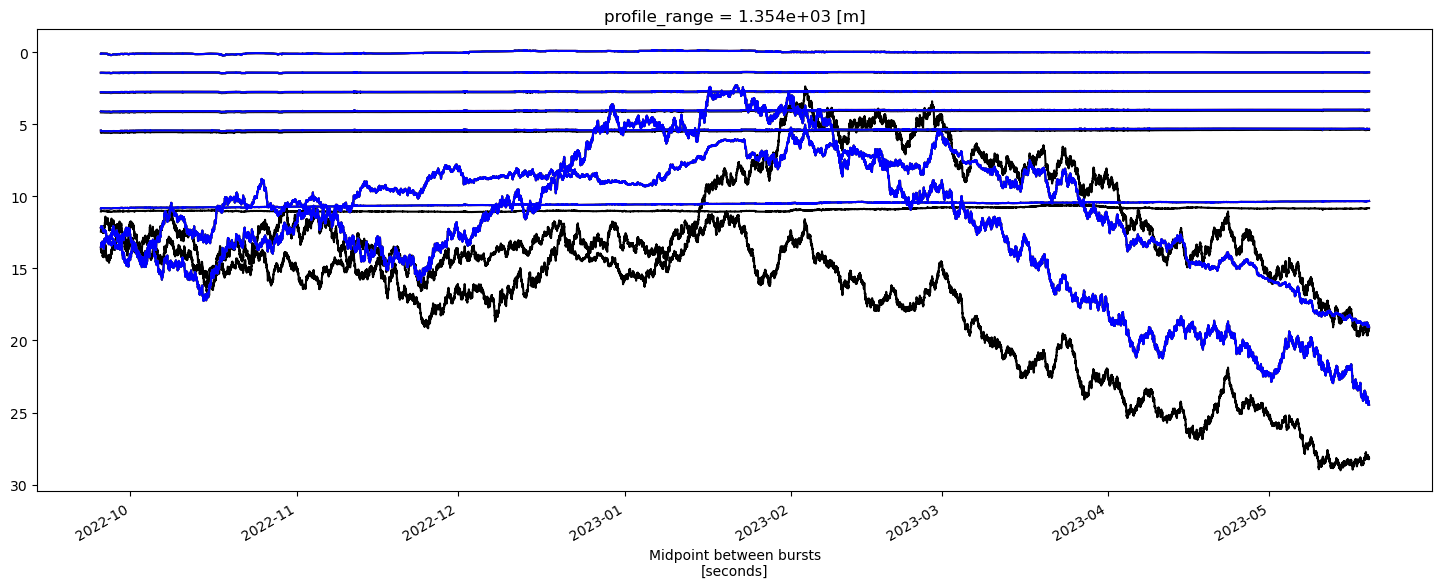

In [25]:
fig, ax = plt.subplots(figsize=(18,6))
da_103_stacked = to_plot
b1= da_103_stacked.isel(time=range(0,len(da_103_stacked)-1))
b2 = da_103_stacked.isel(time=range(1,len(da_103_stacked)))
coherence_steps = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,coherence_steps[i],None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     16:24:37 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [336. 872. 900. ... 900. 900. 900.]s
INFO     16:25:22 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [8408. 8974. 9000. ... 8998. 9000. 9000.]s
INFO     16:26:08 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [89403. 89968. 89996. ... 89978. 90002. 90004.]s
INFO     16:26:52 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [449408. 449972. 449999. ... 450011. 450008. 450003.]s


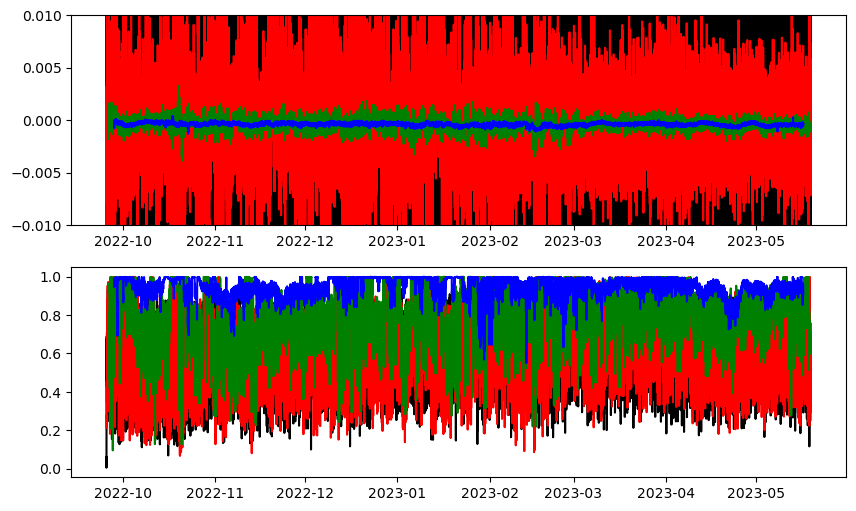

In [26]:
fig, axs = plt.subplots(nrows=2,figsize=(10,6))
da_103_stacked = to_plot

time_windows = [1,10,100,500]
colors = ['k','r','g','b']
for i in range(4):
    b1= da_103_stacked.isel(time=range(0,len(da_103_stacked)-time_windows[i]))
    b2 = da_103_stacked.isel(time=range(time_windows[i],len(da_103_stacked)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,40,20,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95)

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,color=colors[i])
    axs[0].set_ylim([-1e-2,1e-2])
    axs[1].plot(fit.time.values,r2.values,color=colors[i])


In [28]:
del da_103_stacked
del to_plot

NameError: name 'to_plot' is not defined

## Summer 2022
### Profiles

In [29]:
to_plot = ds_103.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 11703, profile_range: 6658)>
array([[ 1.02308835e-02+0.00000000e+00j,  1.00222580e-05+9.01207670e-03j,
        -6.07514336e-03+1.00926123e-05j, ...,
        -6.30472608e-06-6.74847047e-06j,  6.85321573e-06-4.75900967e-06j,
         3.73715976e-06+6.55767974e-06j],
       [ 1.02284554e-02+0.00000000e+00j,  1.18964991e-05+9.01057552e-03j,
        -6.07531431e-03+1.24982102e-05j, ...,
         9.50567269e-06+2.34581981e-06j, -1.54877140e-06+6.04052418e-06j,
        -2.94616642e-06+5.27345772e-07j],
       [ 1.02283446e-02+0.00000000e+00j,  1.35567483e-05+9.01119547e-03j,
        -6.07737027e-03+1.51571232e-05j, ...,
        -1.95594065e-06-1.05697531e-06j,  1.86396618e-06-4.73906169e-07j,
        -3.18912033e-07+1.58375671e-06j],
       ...,
       [ 1.03156488e-02+0.00000000e+00j,  6.08042156e-05+9.05201101e-03j,
        -5.99609663e-03+1.26063658e-04j, ...,
         3.87626309e-06-1.06942226e-05j,  1.60192678e-05+9.60167026e-06j,
        -1.51561212e-05+1.70162215e-05j],
       [ 1.03225132e-02+0.00000000e+00j,  3.50539358e-05+9.06505655e-03j,
        -6.02511056e-03+6.60817784e-05j, ...,
         2.19465535e-06-1.60114937e-05j,  1.56835829e-05+5.10644325e-06j,
        -7.09762922e-06+1.30922022e-05j],
       [ 1.03429722e-02+0.00000000e+00j,  1.69547374e-05+9.09613553e-03j,
        -6.08474581e-03+2.36724059e-05j, ...,
         5.22306027e-07-1.77647140e-06j,  6.33632188e-07+2.16390455e-06j,
        -2.58785719e-06+1.13971437e-07j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 5.0
    burst_number   (time) int64 3 4 5 6 7 8 9 10 11 ... 25 26 27 28 29 30 31 32
    filename       (time) <U83 'ldeo-glaciology/GL_apres_2022/A103/CardA/DIR2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-26T14:13:15 ... 2022-09-25T1...

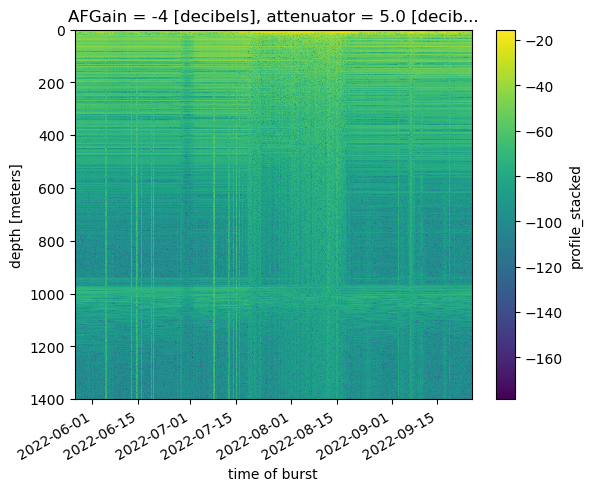

In [30]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

In [31]:
da_103_stacked  = custom_stacked_profile_series(ds_103.chirp.isel(attenuator_setting_pair=0),2,3e8,4e8)


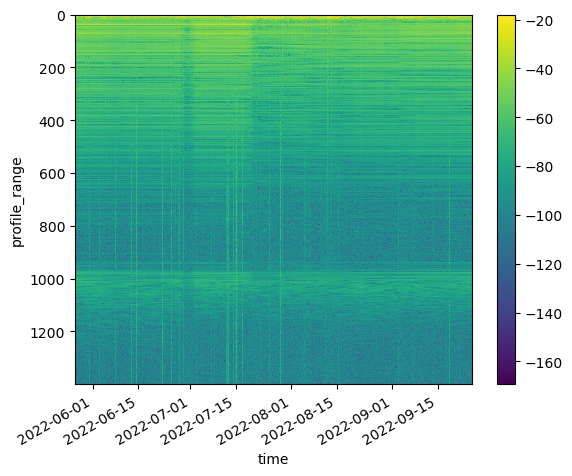

In [32]:
fig, ax = plt.subplots()

xa.dB(da_103_stacked).plot(ax=ax,x='time')
ax.invert_yaxis()

Still some discontinuities

### Strain Rate

INFO     16:34:54 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [905. 906. 888. ... 911. 900. 902.]s
INFO     16:35:14 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [905. 906. 888. ... 911. 900. 902.]s
INFO     16:35:35 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [905. 906. 888. ... 911. 900. 902.]s
INFO     16:35:57 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [905. 906. 888. ... 911. 900. 902.]s


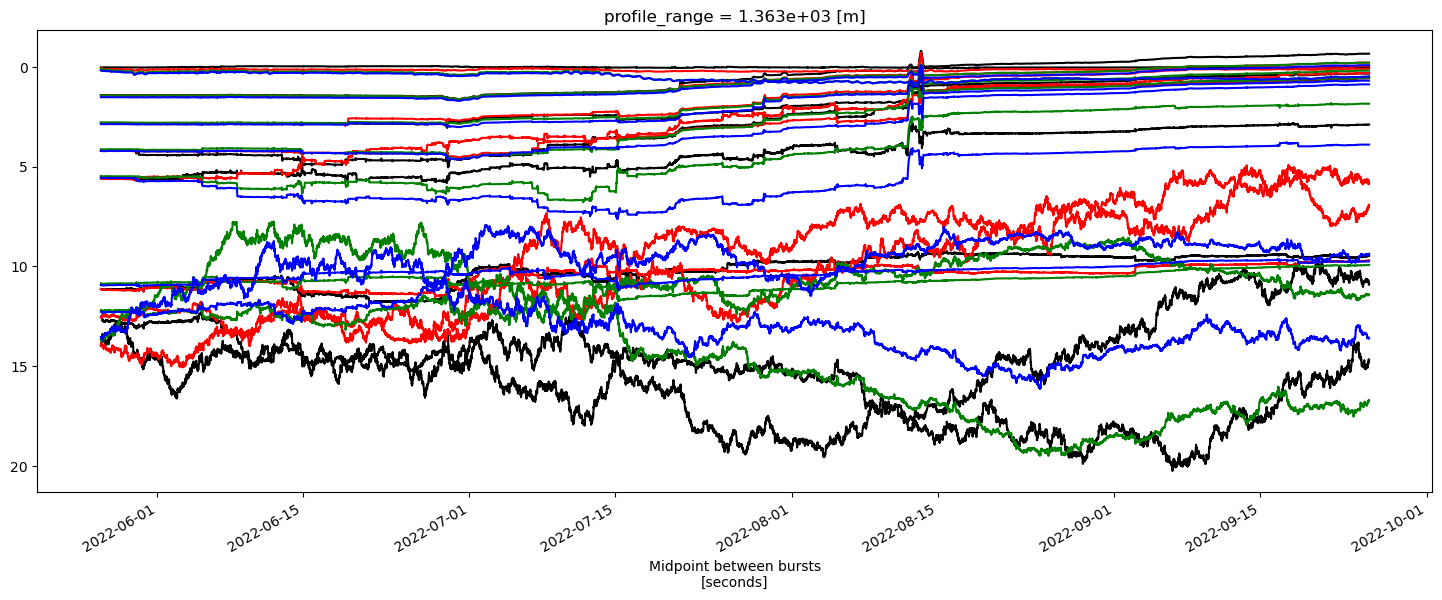

In [33]:
fig, ax = plt.subplots(figsize=(18,6))
b1= da_103_stacked.isel(time=range(0,len(da_103_stacked)-1))
b2 = da_103_stacked.isel(time=range(1,len(da_103_stacked)))
coherence_windows = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,coherence_windows[i],10,None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     16:36:23 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [905. 906. 888. ... 911. 900. 902.]s
INFO     16:36:47 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [905. 906. 888. ... 911. 900. 902.]s
INFO     16:37:00 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [905. 906. 888. ... 911. 900. 902.]s
INFO     16:37:06 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [905. 906. 888. ... 911. 900. 902.]s


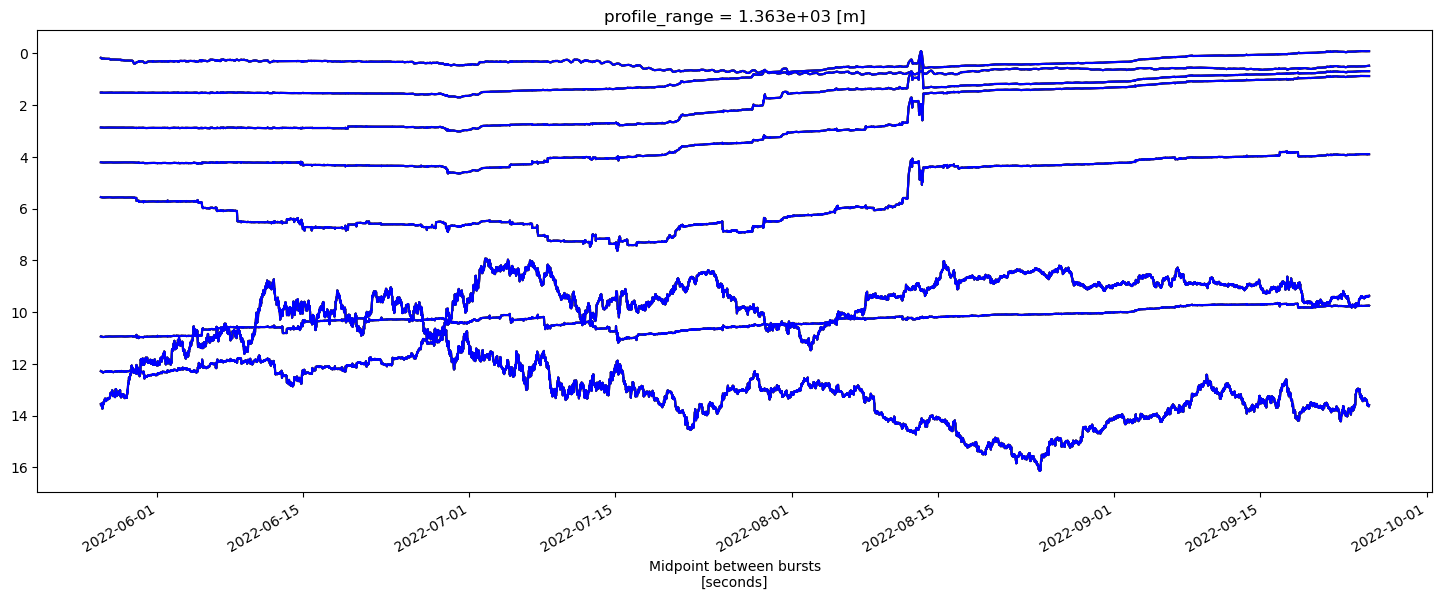

In [34]:
fig, ax = plt.subplots(figsize=(18,6))
b1= da_103_stacked.isel(time=range(0,len(da_103_stacked)-1))
b2 = da_103_stacked.isel(time=range(1,len(da_103_stacked)))
coherence_steps = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,coherence_steps[i],None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     16:37:10 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [905. 906. 888. ... 911. 900. 902.]s
INFO     16:37:22 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [8989. 8984. 8978. ... 8983. 9000. 9002.]s
INFO     16:37:34 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [89997. 89992. 89986. ... 90011. 90011. 90013.]s
INFO     16:37:46 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [449995. 449989. 449984. ... 449951. 450010. 450012.]s


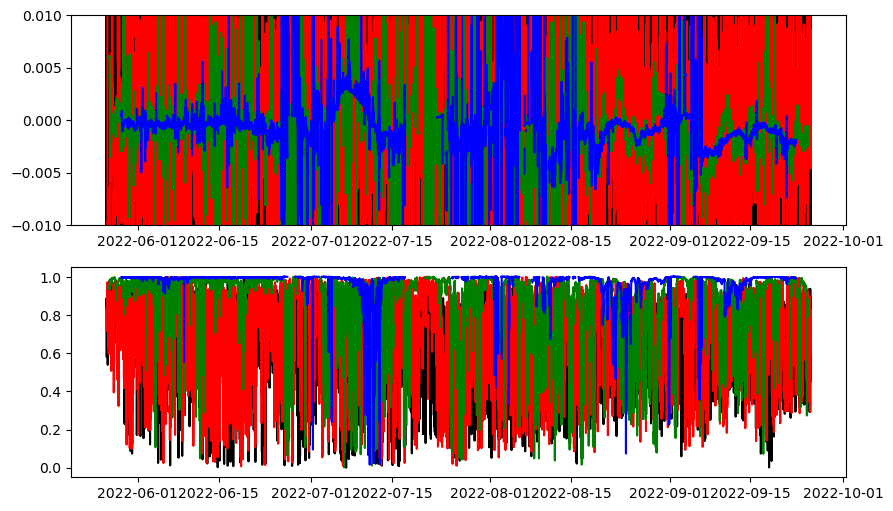

In [35]:
fig, axs = plt.subplots(nrows=2,figsize=(10,6))

time_windows = [1,10,100,500]
colors = ['k','r','g','b']
for i in range(4):
    b1= da_103_stacked.isel(time=range(0,len(da_103_stacked)-time_windows[i]))
    b2 = da_103_stacked.isel(time=range(time_windows[i],len(da_103_stacked)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,40,20,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95)

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,color=colors[i])
    axs[0].set_ylim([-1e-2,1e-2])
    axs[1].plot(fit.time.values,r2.values,color=colors[i])


In [36]:
del da_103_stacked
del to_plot

## Summer 2023
### Profiles

In [37]:
to_plot = ds_103_s.profile_stacked.isel(attenuator_setting_pair=2).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 47375, profile_range: 6658)>
array([[ 9.19800954e-03+0.00000000e+00j,  5.52394037e-05+8.10151394e-03j,
        -5.45780266e-03+8.17386866e-05j, ...,
         9.88636013e-06-1.04125794e-05j,  7.10000536e-06+1.42066659e-05j,
        -1.73388604e-05+2.44340125e-06j],
       [ 9.19597612e-03+0.00000000e+00j,  5.95976287e-05+8.09215737e-03j,
        -5.43168435e-03+8.84741132e-05j, ...,
         6.86177128e-06-4.48617900e-06j,  2.81556616e-06+5.42631563e-06j,
        -3.07784205e-06+1.64977894e-06j],
       [ 9.23264721e-03+0.00000000e+00j,  2.75891083e-05+8.12843044e-03j,
        -5.47332826e-03+2.90162459e-05j, ...,
        -4.94086782e-06-7.10397831e-06j,  6.93263364e-06+4.25182933e-06j,
        -1.13287479e-05+3.25014158e-06j],
       ...,
       [ 7.54182075e-03+0.00000000e+00j,  3.03062846e-04+6.51616874e-03j,
        -4.12460427e-03+5.22526494e-04j, ...,
         1.09276380e-05+3.75081431e-06j, -6.01063369e-06+8.86154641e-06j,
        -4.70097383e-06-5.30704770e-06j],
       [ 8.71610576e-03+0.00000000e+00j, -1.43786918e-04+7.61086407e-03j,
        -4.97294054e-03-3.31105568e-04j, ...,
        -1.25316083e-05-5.83971106e-06j,  1.16154362e-05-7.27121723e-06j,
         1.24448610e-07+1.08294057e-05j],
       [ 8.07795154e-03+0.00000000e+00j, -3.36803370e-04+6.91572211e-03j,
        -4.13054797e-03-5.27644844e-04j, ...,
         7.48121242e-05+8.76399819e-05j, -4.62783759e-05+8.29985982e-05j,
        -9.03811330e-05-3.09358776e-06j]])
Coordinates:
    AFGain         int64 6
    attenuator     float64 15.0
    burst_number   (time) int64 0 0 1 2 3 0 1 0 1 ... 46 47 48 49 50 51 52 53 54
    filename       (time) <U87 'ldeo-glaciology/GL_apres_2022/A103/summer_23/...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2023-05-19T14:15:59 ... 2023-08-31T1...

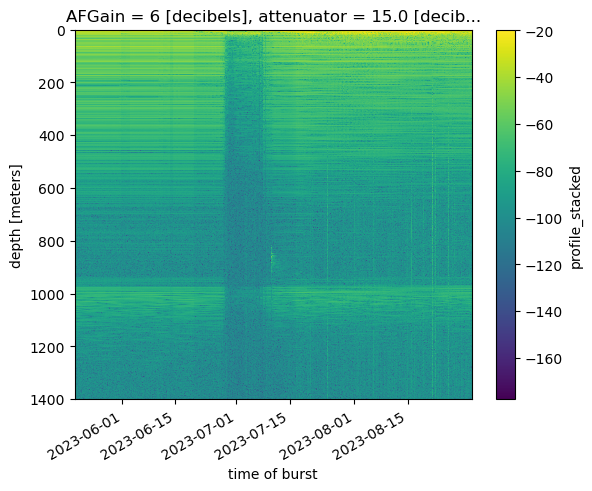

In [38]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

Even with strongest attenuation settings, some bad data. Try applying half chirp.

In [39]:
da_103_stacked  = custom_stacked_profile_series(ds_103_s.chirp.isel(attenuator_setting_pair=2),2,3e8,4e8)


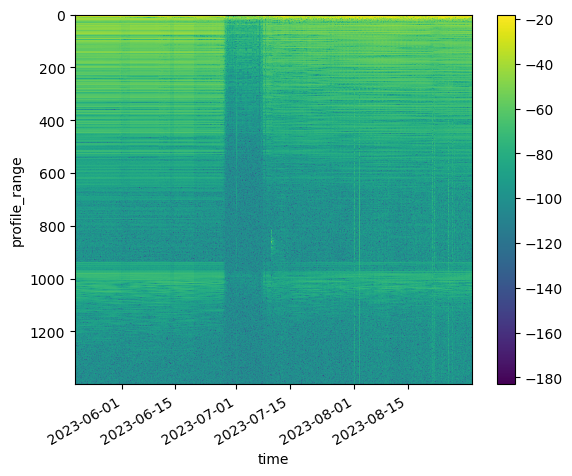

In [40]:
fig, ax = plt.subplots()

xa.dB(da_103_stacked).plot(ax=ax,x='time')
ax.invert_yaxis()

### Strain Rate

INFO     17:01:57 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [599. 885. 909. ... 305. 313. 312.]s
INFO     17:03:19 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [599. 885. 909. ... 305. 313. 312.]s
INFO     17:04:44 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [599. 885. 909. ... 305. 313. 312.]s
INFO     17:06:15 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [599. 885. 909. ... 305. 313. 312.]s


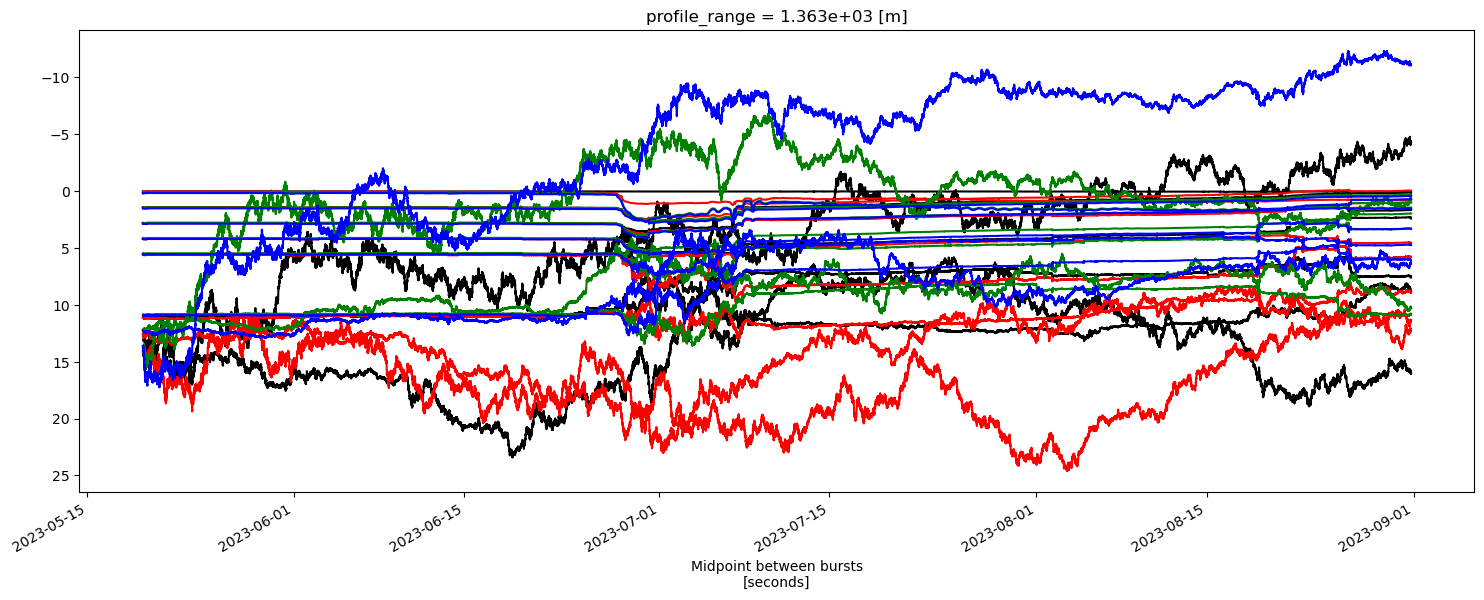

In [41]:
fig, ax = plt.subplots(figsize=(18,6))
b1= da_103_stacked.isel(time=range(0,len(da_103_stacked)-1))
b2 = da_103_stacked.isel(time=range(1,len(da_103_stacked)))
coherence_windows = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,coherence_windows[i],10,None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     17:07:56 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [599. 885. 909. ... 305. 313. 312.]s
INFO     17:09:35 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [599. 885. 909. ... 305. 313. 312.]s
INFO     17:10:25 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [599. 885. 909. ... 305. 313. 312.]s
INFO     17:10:51 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [599. 885. 909. ... 305. 313. 312.]s


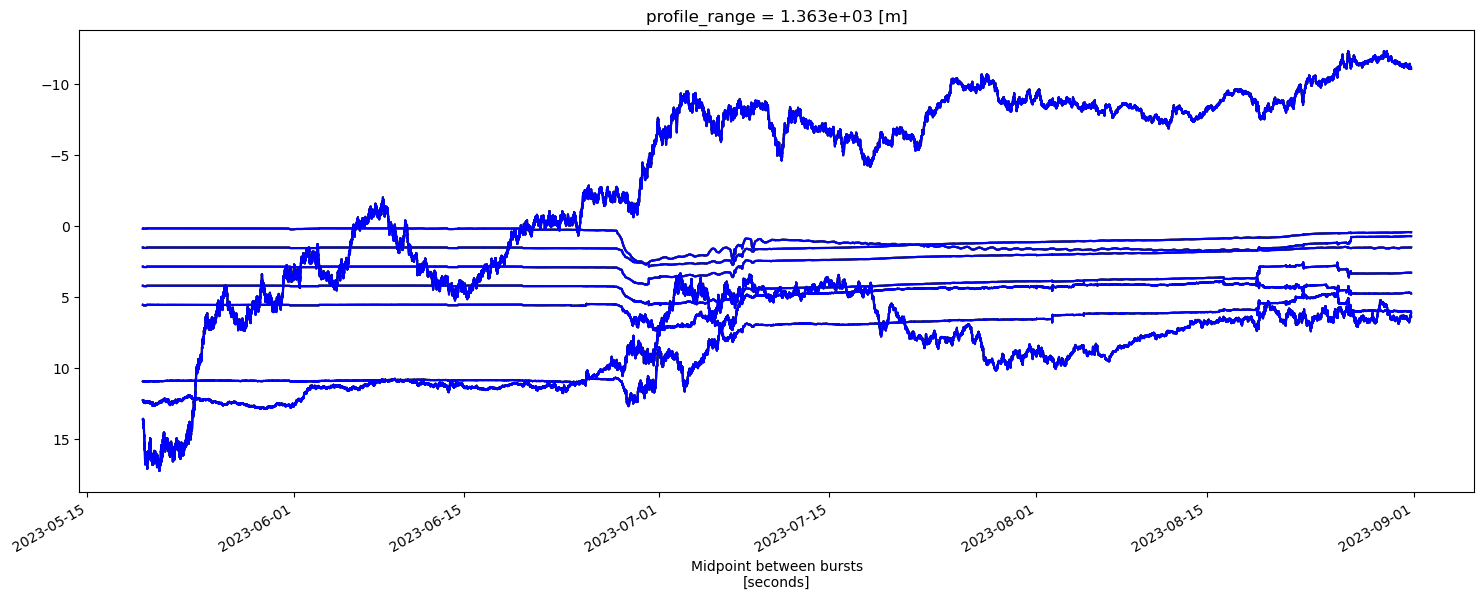

In [42]:
fig, ax = plt.subplots(figsize=(18,6))
b1= da_103_stacked.isel(time=range(0,len(da_103_stacked)-1))
b2 = da_103_stacked.isel(time=range(1,len(da_103_stacked)))
coherence_steps = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,coherence_steps[i],None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     18:10:25 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [599. 885. 909. ... 305. 313. 312.]s


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


INFO     18:11:13 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [4070. 3471. 2586. ... 3113. 3115. 3114.]s
INFO     18:12:01 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [ 9833.  9312.  8506. ... 31062. 31062. 31062.]s
INFO     18:12:49 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [ 40377.  39851.  39037. ... 153438. 153452. 153464.]s


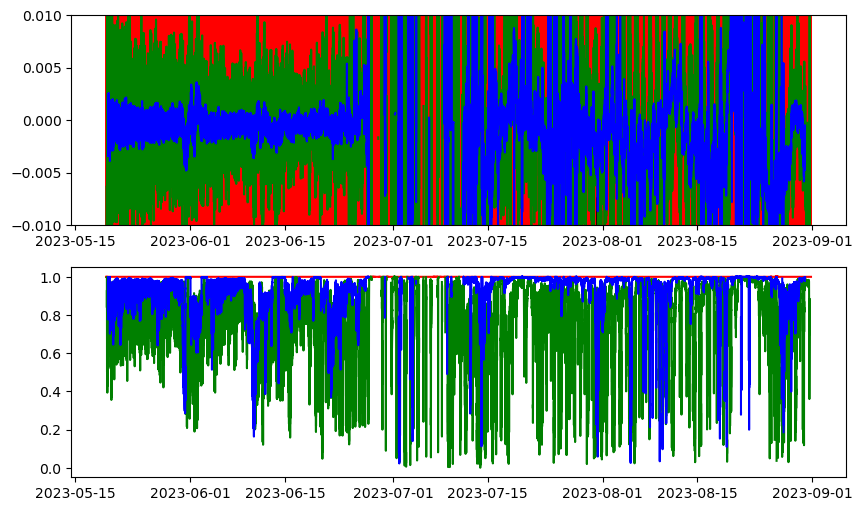

In [49]:
fig, axs = plt.subplots(nrows=2,figsize=(10,6))

time_windows = [1,10,100,500]
colors = ['k','r','g','b']
for i in range(4):
    b1= da_103_stacked.isel(time=range(0,len(da_103_stacked)-time_windows[i]))
    b2 = da_103_stacked.isel(time=range(time_windows[i],len(da_103_stacked)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,40,20,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95)

    vv = (ds_new.range_diff / ds_new.time_diff * 31536000).drop_duplicates('time')
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,color=colors[i])
    axs[0].set_ylim([-1e-2,1e-2])
    axs[1].plot(fit.time.values,r2.values,color=colors[i])


In [50]:
del da_103_stacked
del to_plot

# Station A14

## Winter 2023
### Profiles
We will use settings A= 5dB and G = -4 dB.

In [51]:
to_plot = ds_104_w.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 11201, profile_range: 6658)>
array([[ 8.80516206e-03+0.00000000e+00j,  1.14958270e-06+7.75084305e-03j,
        -5.21840911e-03+1.22791724e-06j, ...,
        -2.38226657e-07-4.41114976e-06j,  5.65078426e-06+1.47887150e-06j,
        -3.07353616e-06+5.15813545e-06j],
       [ 8.80085204e-03+0.00000000e+00j,  5.78474130e-07+7.74830037e-03j,
        -5.21932195e-03+6.05488026e-06j, ...,
         8.95547533e-06+9.24833916e-06j, -5.84101059e-06+3.42340600e-06j,
         2.85464413e-06+1.07120683e-06j],
       [ 8.79510439e-03+0.00000000e+00j,  2.32397834e-05+7.73934344e-03j,
        -5.20173885e-03+4.75407695e-05j, ...,
        -8.45240884e-06+8.90665308e-06j, -5.76373446e-06-7.19777338e-06j,
         3.64589257e-06-3.63626366e-06j],
       ...,
       [ 8.51345397e-03+0.00000000e+00j,  1.63450933e-05+7.49491564e-03j,
        -5.04592275e-03+3.44893686e-05j, ...,
         7.09639529e-06-6.82143287e-06j,  5.98943718e-06+5.24983288e-06j,
        -2.24761005e-06+5.32171017e-06j],
       [ 8.50942953e-03+0.00000000e+00j,  1.62989498e-05+7.49137915e-03j,
        -5.04355413e-03+3.43977366e-05j, ...,
         2.37997308e-06-3.28566661e-06j,  9.79965105e-07+1.85305971e-06j,
        -8.77553590e-07-5.24382112e-07j],
       [ 8.50958087e-03+0.00000000e+00j,  1.63166334e-05+7.49148300e-03j,
        -5.04355042e-03+3.44315112e-05j, ...,
         4.59180500e-06-3.68574946e-06j,  2.93178779e-06+3.15136667e-06j,
        -1.76477788e-06+1.91200500e-06j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 10.0
    burst_number   (time) int64 0 0 1 2 3 4 5 6 7 ... 57 58 59 60 61 62 63 64 65
    filename       (time) <U89 'ldeo-glaciology/GL_apres_2022/A104/winter22_2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-09-25T13:49:28 ... 2023-03-24T0...

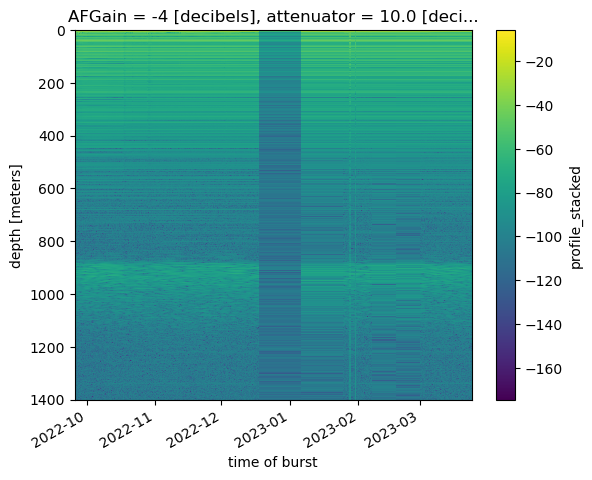

In [52]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

### Strain Rates

INFO     18:17:04 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [332. 870. 900. ... 901. 900. 899.]s
INFO     18:17:41 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [332. 870. 900. ... 901. 900. 899.]s
INFO     18:18:20 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [332. 870. 900. ... 901. 900. 899.]s
INFO     18:19:03 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [332. 870. 900. ... 901. 900. 899.]s


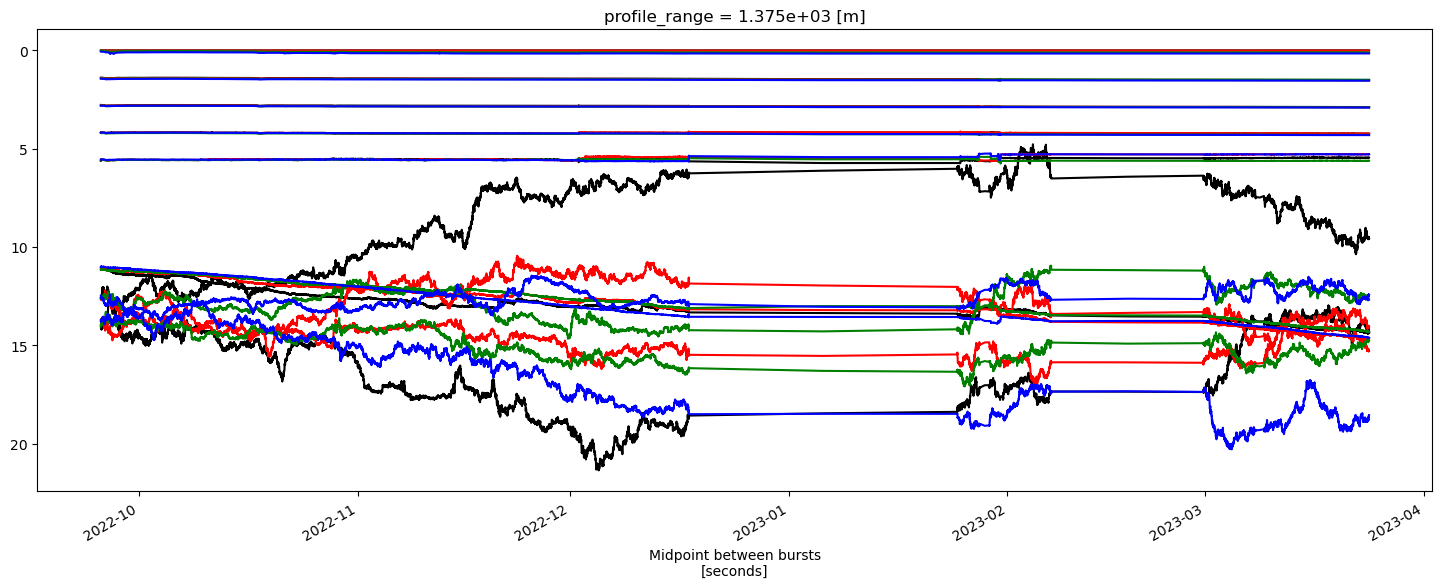

In [53]:
fig, ax = plt.subplots(figsize=(18,6))
da_104_stacked = to_plot
b1= da_104_stacked.isel(time=range(0,len(da_104_stacked)-1))
b2 = da_104_stacked.isel(time=range(1,len(da_104_stacked)))
coherence_windows = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,coherence_windows[i],10,None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     18:19:51 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [332. 870. 900. ... 901. 900. 899.]s
INFO     18:20:38 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [332. 870. 900. ... 901. 900. 899.]s
INFO     18:21:01 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [332. 870. 900. ... 901. 900. 899.]s
INFO     18:21:13 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [332. 870. 900. ... 901. 900. 899.]s


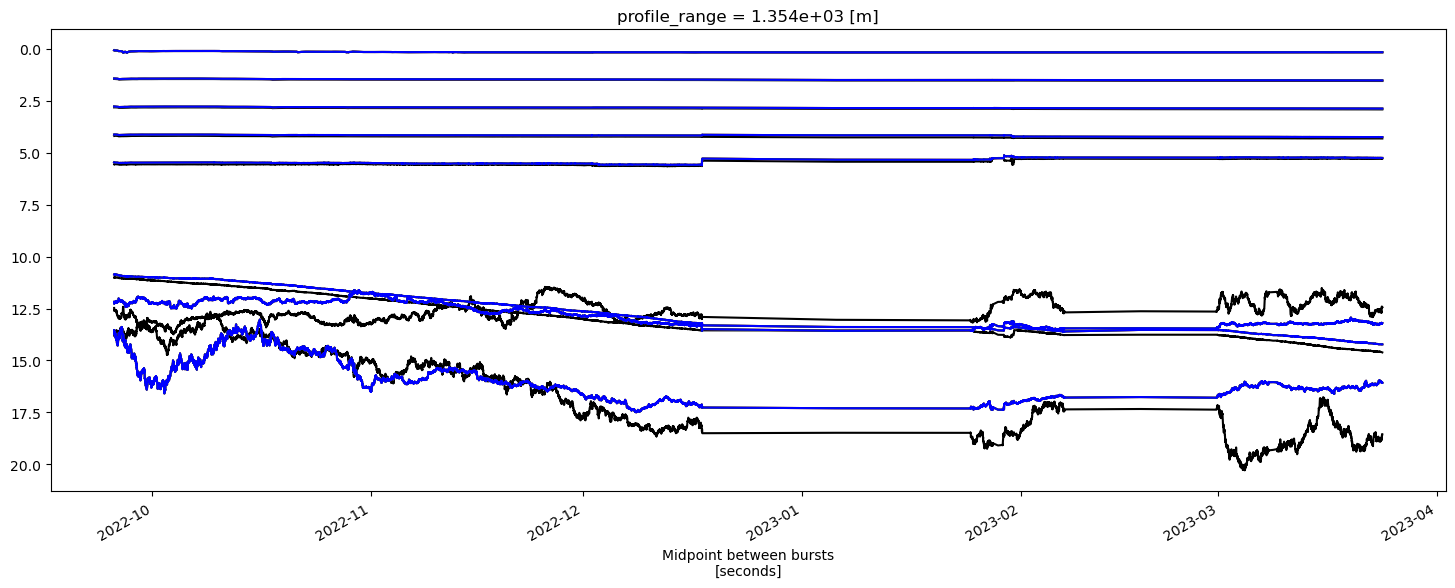

In [54]:
fig, ax = plt.subplots(figsize=(18,6))
da_104_stacked = to_plot
b1= da_104_stacked.isel(time=range(0,len(da_104_stacked)-1))
b2 = da_104_stacked.isel(time=range(1,len(da_104_stacked)))
coherence_steps = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,coherence_steps[i],None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     18:21:20 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [332. 870. 900. ... 901. 900. 899.]s
INFO     18:21:42 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [8403. 8987. 8999. ... 9003. 9003. 9002.]s
INFO     18:22:04 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [89394. 89960. 89993. ... 89996. 90006. 90005.]s
INFO     18:22:26 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [449403. 449972. 449998. ... 449651. 449645. 449644.]s


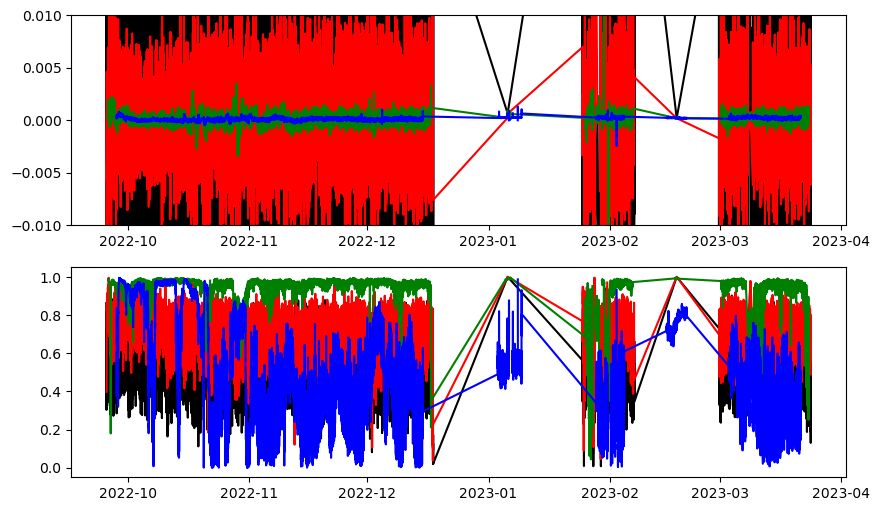

In [55]:
fig, axs = plt.subplots(nrows=2,figsize=(10,6))
da_104_stacked = to_plot

time_windows = [1,10,100,500]
colors = ['k','r','g','b']
for i in range(4):
    b1= da_104_stacked.isel(time=range(0,len(da_104_stacked)-time_windows[i]))
    b2 = da_104_stacked.isel(time=range(time_windows[i],len(da_104_stacked)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,40,20,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95)

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,color=colors[i])
    axs[0].set_ylim([-1e-2,1e-2])
    axs[1].plot(fit.time.values,r2.values,color=colors[i])


## Summer 2022
### Profiles

In [57]:
to_plot = ds_104.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 11691, profile_range: 6658)>
array([[ 8.81878605e-03+0.00000000e+00j,  1.62365534e-05+7.76312337e-03j,
        -5.22810185e-03+3.26968996e-05j, ...,
        -3.45174032e-06-2.93691793e-07j, -5.80575504e-07-2.81518347e-06j,
         2.55956166e-06-8.39930162e-07j],
       [ 8.81119275e-03+0.00000000e+00j,  2.37921821e-05+7.76266423e-03j,
        -5.24084157e-03+3.77737222e-05j, ...,
        -2.29927173e-06-4.60340778e-06j,  5.81694072e-06-8.86534169e-07j,
        -3.68193049e-07+5.12190181e-06j],
       [ 8.80590805e-03+0.00000000e+00j,  2.40407112e-05+7.75739510e-03j,
        -5.23592789e-03+3.83429495e-05j, ...,
         1.58905469e-06-1.93774065e-06j,  2.90899184e-06+1.56215465e-06j,
        -1.96439424e-06+3.27690807e-06j],
       ...,
       [ 8.84754907e-03+0.00000000e+00j,  1.79986287e-05+7.78881278e-03j,
        -5.24766387e-03+3.79867779e-05j, ...,
         1.86732104e-06-3.12621192e-06j,  3.41587500e-06+1.20198428e-06j,
        -5.81846573e-07+3.72058561e-06j],
       [ 8.84218553e-03+0.00000000e+00j,  1.81174958e-05+7.78410587e-03j,
        -5.24460969e-03+3.83339077e-05j, ...,
         5.00562523e-06-3.43150849e-06j,  3.34773226e-06+4.78503949e-06j,
        -4.42320356e-06+3.71893028e-06j],
       [ 8.84541217e-03+0.00000000e+00j,  1.80494942e-05+7.78694987e-03j,
        -5.24650157e-03+3.82083253e-05j, ...,
         1.86884159e-06-2.09339717e-06j,  4.41743931e-07+1.37195154e-06j,
        -6.10335028e-07-1.11939795e-06j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 10.0
    burst_number   (time) int64 3 4 5 6 7 8 9 10 11 12 ... 5 6 7 8 9 10 11 12 13
    filename       (time) <U83 'ldeo-glaciology/GL_apres_2022/A104/CardA/DIR2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-26T18:33:17 ... 2022-09-25T1...

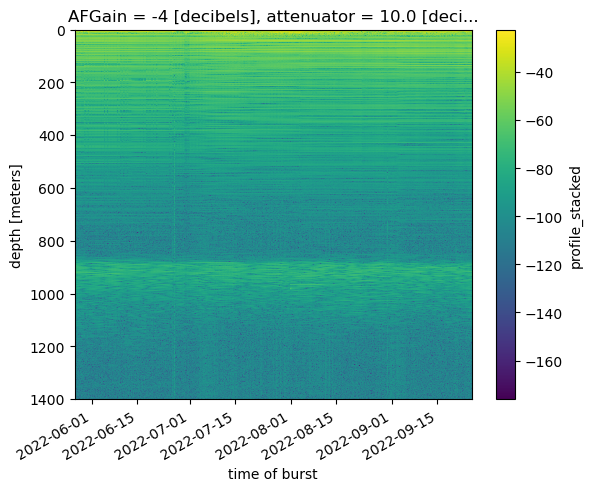

In [58]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

### Strain Rate

INFO     18:32:30 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [913. 876. 900. ... 903. 905. 897.]s
INFO     18:33:11 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [913. 876. 900. ... 903. 905. 897.]s
INFO     18:33:54 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [913. 876. 900. ... 903. 905. 897.]s
INFO     18:34:39 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [913. 876. 900. ... 903. 905. 897.]s


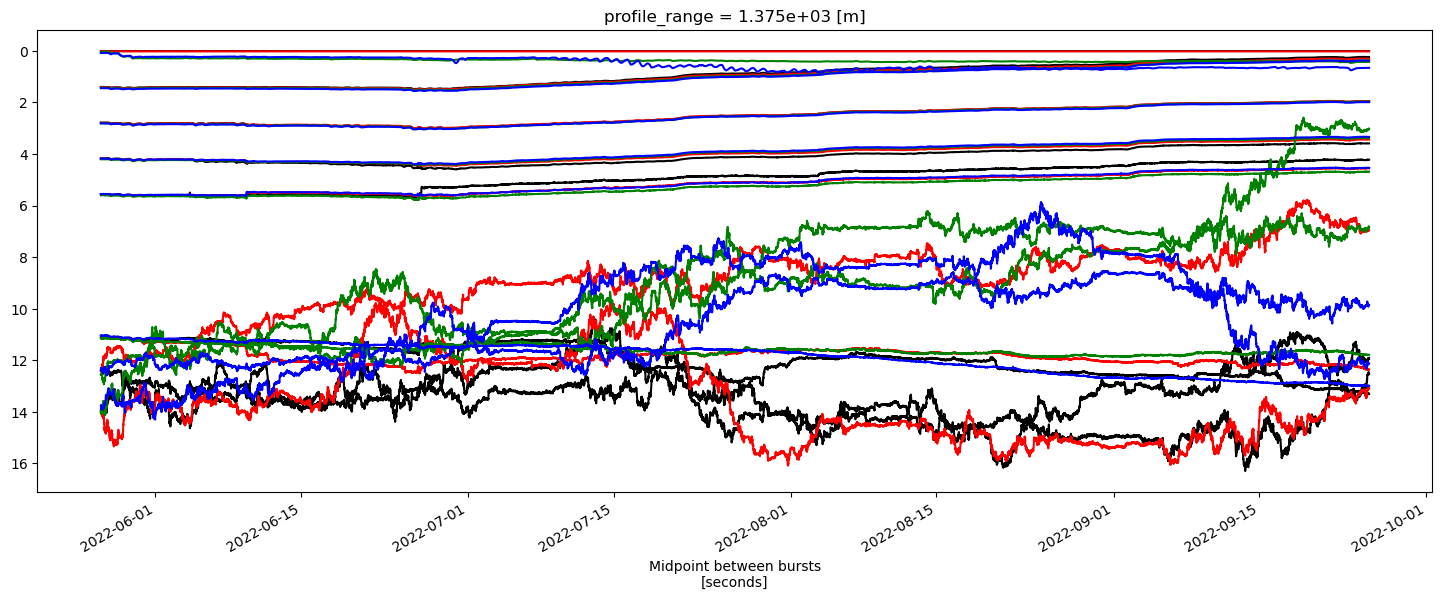

In [61]:
da_104_stacked = to_plot
fig, ax = plt.subplots(figsize=(18,6))
b1= da_104_stacked.isel(time=range(0,len(da_104_stacked)-1))
b2 = da_104_stacked.isel(time=range(1,len(da_104_stacked)))
coherence_windows = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,coherence_windows[i],10,None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     18:35:30 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [913. 876. 900. ... 903. 905. 897.]s
INFO     18:36:20 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [913. 876. 900. ... 903. 905. 897.]s
INFO     18:36:44 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [913. 876. 900. ... 903. 905. 897.]s
INFO     18:36:57 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [913. 876. 900. ... 903. 905. 897.]s


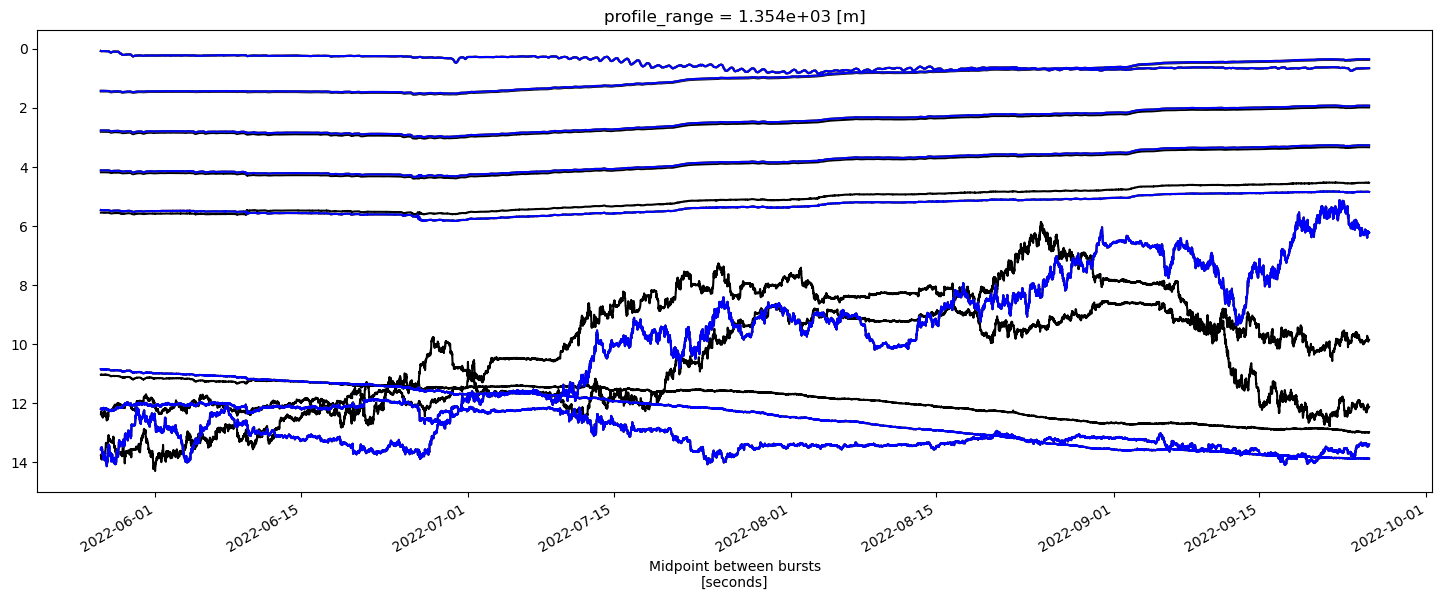

In [62]:
fig, ax = plt.subplots(figsize=(18,6))
b1= da_104_stacked.isel(time=range(0,len(da_104_stacked)-1))
b2 = da_104_stacked.isel(time=range(1,len(da_104_stacked)))
coherence_steps = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,coherence_steps[i],None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


INFO     18:37:04 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [913. 876. 900. ... 903. 905. 897.]s
INFO     18:37:28 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [8996. 8983. 9007. ... 9007. 9012. 9009.]s
INFO     18:37:52 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [89988. 89977. 90000. ... 90009. 90014. 90011.]s
INFO     18:38:15 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [450001. 449988. 450012. ... 450016. 450010. 450016.]s


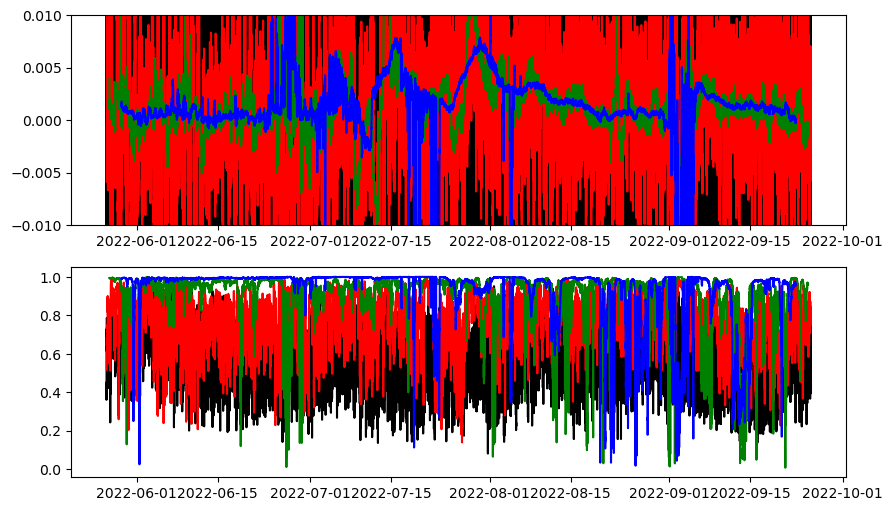

In [63]:
fig, axs = plt.subplots(nrows=2,figsize=(10,6))

time_windows = [1,10,100,500]
colors = ['k','r','g','b']
for i in range(4):
    b1= da_104_stacked.isel(time=range(0,len(da_104_stacked)-time_windows[i]))
    b2 = da_104_stacked.isel(time=range(time_windows[i],len(da_104_stacked)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,40,20,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95)

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,color=colors[i])
    axs[0].set_ylim([-1e-2,1e-2])
    axs[1].plot(fit.time.values,r2.values,color=colors[i])


## Summer 2023
### Profiles

In [4]:
to_plot = ds_104_s.profile_stacked.isel(attenuator_setting_pair=2).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 9705, profile_range: 6658)>
array([[ 6.90209091e-03+0.00000000e+00j,  2.42593613e-05+6.09164209e-03j,
        -4.13034005e-03+1.27284119e-05j, ...,
        -2.50450295e-05-5.22284476e-05j,  4.93118025e-05-2.56404066e-05j,
         2.73944634e-05+4.70562691e-05j],
       [ 7.13987350e-03+0.00000000e+00j,  6.66329496e-06+6.32041815e-03j,
        -4.35863012e-03-1.97847168e-05j, ...,
         1.50141838e-05-4.15628314e-05j,  2.63321178e-05+8.37278124e-06j,
         5.68318231e-06+5.37058406e-06j],
       [ 6.91576323e-03+0.00000000e+00j,  3.38477554e-05+6.09168623e-03j,
        -4.10280165e-03+4.87027573e-05j, ...,
         6.63143543e-06-4.70367091e-07j,  7.62201895e-09+2.97189305e-06j,
        -1.24378796e-06-1.35609048e-06j],
       ...,
       [ 6.80257361e-03+0.00000000e+00j,  8.09933514e-05+6.01874967e-03j,
        -4.10613471e-03+1.04786094e-04j, ...,
         3.84400303e-06-1.94657886e-05j,  1.91718203e-05+3.25572654e-06j,
        -3.71898298e-06+1.92350305e-05j],
       [ 6.80752264e-03+0.00000000e+00j,  7.61839086e-05+6.01937738e-03j,
        -4.09999152e-03+1.03248272e-04j, ...,
         8.43020158e-06-2.63512885e-05j,  2.67696158e-05+5.06315768e-06j,
        -5.54165922e-06+2.37833386e-05j],
       [ 6.82277805e-03+0.00000000e+00j,  6.82720686e-05+6.02777924e-03j,
        -4.09678637e-03+9.83136194e-05j, ...,
         6.72706430e-06-1.48169190e-05j,  1.41352098e-05+3.27820401e-06j,
        -4.67550219e-06+1.19152740e-05j]])
Coordinates:
    AFGain         int64 6
    attenuator     float64 15.0
    burst_number   (time) int64 0 0 1 2 3 4 5 6 7 ... 45 46 47 48 49 50 51 52 53
    filename       (time) <U87 'ldeo-glaciology/GL_apres_2022/A104/summer_23/...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2023-05-22T17:04:27 ... 2023-08-31T1...

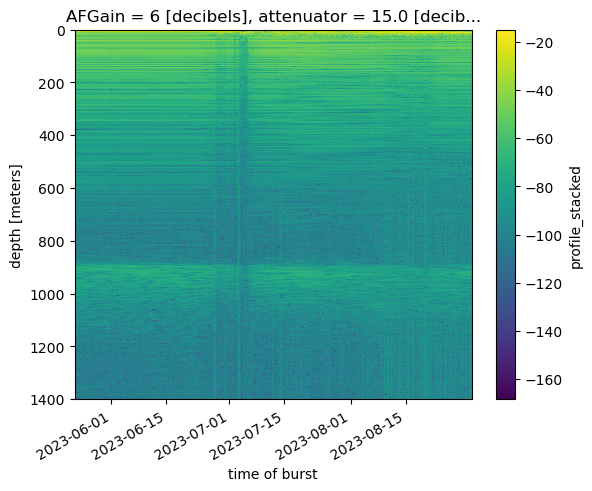

In [5]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

In [8]:
da_104_stacked  = custom_stacked_profile_series(ds_104_s.chirp.isel(attenuator_setting_pair=0),2,3e8,4e8)


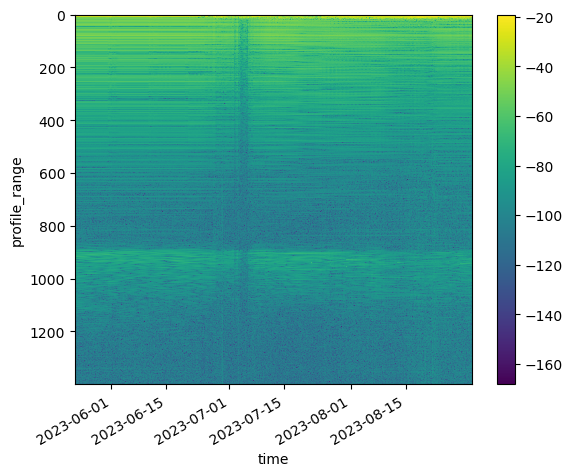

In [9]:
fig, ax = plt.subplots()

xa.dB(da_104_stacked).plot(ax=ax,x='time')
ax.invert_yaxis()

### Strain Rate

In [96]:
# Test to find optimal cohrence window, step, lag
def strain_metrics(ds, win_cor, step, lag):
    # This function, given a window, and step, gives a total percentage of data that has high coherence
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,step,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95)

    vv = dz_new.range_diff / dz_new.time_diff * 31536000
    vv_err = dz_new.err / dz_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    return np.count_nonzero(abs(co)>0.95)/np.count_nonzero(co), np.mean(abs(co)), np.mean(r2).values

def optimal_window_and_leapfrog(ds):
    max_score = 0
    windows = np.arange(10,100,10)
    lags = np.round(np.logspace(0,3,10)).astype('int')
    pct_mat = np.zeros((len(windows),len(lags)))
    r2_mat = np.zeros((len(windows),len(lags)))
    for i in range(len(windows)):
        step = window # earlier experiments show step doesn't change results by much
        #for step in [10,20,40,80]:
        #    if step <= window:
        for j in range(len(lags)):
            pct,mean,r2 = strain_metrics(ds, windows[i], step,lags[j])
            print(f"Window {windows[i]}, lag {lags[j]} -> pct {pct:.2}, r2 {r2:.2}")
            pct_mat[i,j] = pct
            r2_mat[i,j]=r2
            # mean coherence not relevant I think
            temp_score = pct+r2
            if temp_score > max_score:
                max_score = temp_score
            to_return = windows[i],lags[j]
            
    fig, axs = plt.subplots(ncols=2,figsize=(15,5))
    plt0 = axs[0].pcolormesh(100*pct_mat)
    plt.colorbar(plt0,ax=axs[0],label='percentage of data with high coherence (>0.95)')
    axs[0].set_xticks(np.arange(pct_mat.shape[1]) + 0.5, minor=False)
    axs[0].set_yticks(np.arange(pct_mat.shape[0]) + 0.5, minor=False)
    axs[0].set_xticklabels(lags)
    axs[0].set_yticklabels(windows)
    axs[0].set_ylabel('Correlation window size [points included]')
    axs[0].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[0].set_title('High coherence percentage')


    plt1 = axs[1].pcolormesh(r2_mat)
    plt.colorbar(plt1,ax=axs[1],label='Average r^2 of linear strain fits')
    axs[1].set_xticks(np.arange(r2_mat.shape[1]) + 0.5, minor=False)
    axs[1].set_yticks(np.arange(r2_mat.shape[0]) + 0.5, minor=False)
    axs[1].set_xticklabels(lags)
    axs[1].set_yticklabels(windows)
    axs[1].set_ylabel('Correlation window size [points included]')
    axs[1].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[1].set_title('Mean strain rate fit r-squared')

    return to_return

Window 10, lag 1 -> pct 0.56, r2 0.76
Window 10, lag 2 -> pct 0.56, r2 0.76
Window 10, lag 5 -> pct 0.55, r2 0.76
Window 10, lag 10 -> pct 0.53, r2 0.77
Window 10, lag 22 -> pct 0.49, r2 0.8
Window 10, lag 46 -> pct 0.43, r2 0.83
Window 10, lag 100 -> pct 0.39, r2 0.84
Window 10, lag 215 -> pct 0.32, r2 0.8
Window 10, lag 464 -> pct 0.24, r2 0.8
Window 10, lag 1000 -> pct 0.17, r2 0.59
Window 20, lag 1 -> pct 0.52, r2 0.66
Window 20, lag 2 -> pct 0.51, r2 0.67
Window 20, lag 5 -> pct 0.5, r2 0.69
Window 20, lag 10 -> pct 0.48, r2 0.74
Window 20, lag 22 -> pct 0.44, r2 0.81
Window 20, lag 46 -> pct 0.38, r2 0.85
Window 20, lag 100 -> pct 0.34, r2 0.81
Window 20, lag 215 -> pct 0.26, r2 0.86
Window 20, lag 464 -> pct 0.17, r2 0.88
Window 20, lag 1000 -> pct 0.12, r2 0.6
Window 30, lag 1 -> pct 0.51, r2 0.61
Window 30, lag 2 -> pct 0.51, r2 0.63
Window 30, lag 5 -> pct 0.49, r2 0.68
Window 30, lag 10 -> pct 0.47, r2 0.76
Window 30, lag 22 -> pct 0.42, r2 0.85
Window 30, lag 46 -> pct 0.36

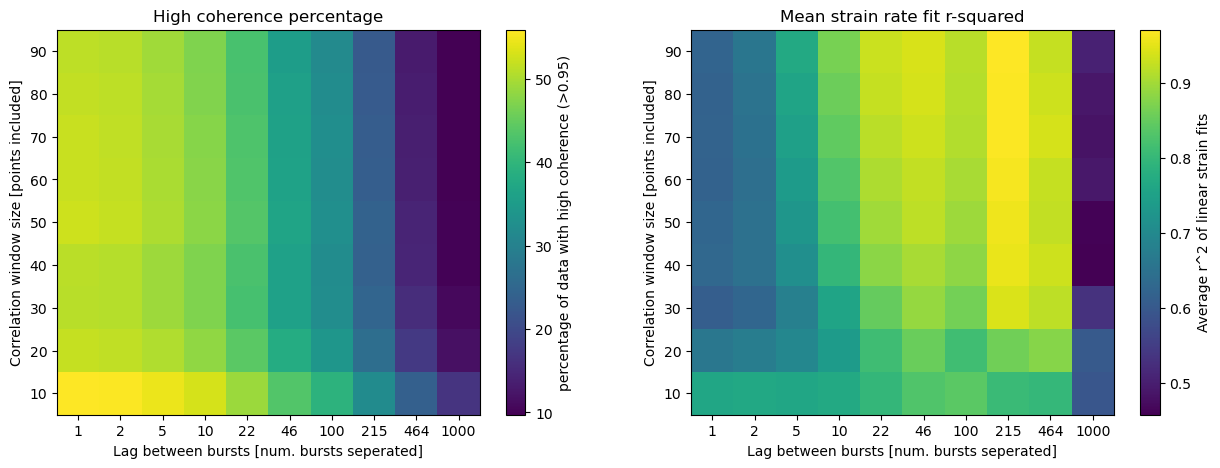

In [98]:
# test finding optimal strain rates
best_window,best_lag = optimal_window_and_leapfrog(da_104_stacked)
            

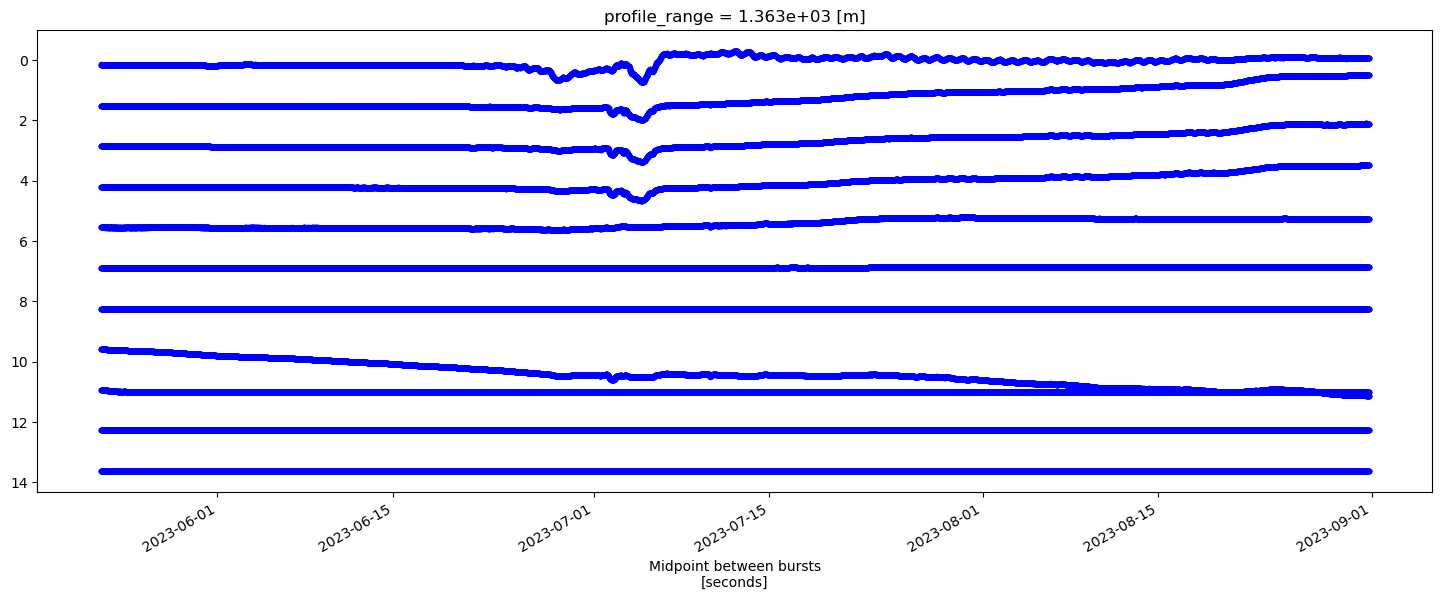

In [100]:
fig, ax = plt.subplots(figsize=(18,6))
b1= da_104_stacked.isel(time=range(0,len(da_104_stacked)-1))
b2 = da_104_stacked.isel(time=range(1,len(da_104_stacked)))
coherence_windows = [10,20,40,80]
colors = ['k','r','g','b']
for i in [3]:
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,coherence_windows[i],10,None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_full = ds_full.where(abs(ds_full.coherence) > 0.95)

    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
        disp.plot(ax=ax,x='time',color=colors[i],marker='.',linestyle='None')
        count += 1
ax.invert_yaxis()


INFO     18:49:49 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [564. 874. 900. ... 900. 900. 898.]s
INFO     18:50:09 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [564. 874. 900. ... 900. 900. 898.]s
INFO     18:50:19 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [564. 874. 900. ... 900. 900. 898.]s
INFO     18:50:24 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [564. 874. 900. ... 900. 900. 898.]s


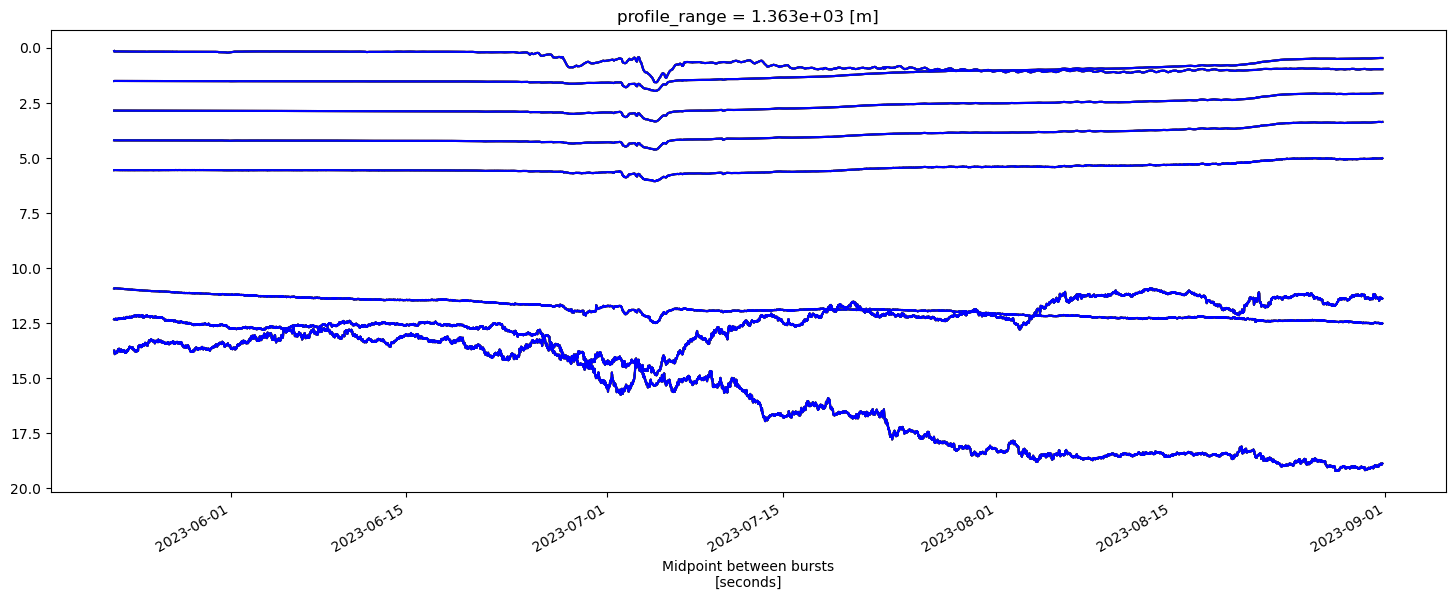

In [71]:
fig, ax = plt.subplots(figsize=(18,6))
b1= da_104_stacked.isel(time=range(0,len(da_104_stacked)-1))
b2 = da_104_stacked.isel(time=range(1,len(da_104_stacked)))
coherence_steps = [10,20,40,80]
colors = ['k','r','g','b']
for i in range(4):
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,coherence_steps[i],None,0,0.95)
    #tot_disp = ds_full.range_diff.sum(dim='time')
    #ax.plot(tot_disp,tot_disp.profile_range,color=colors[i])
    count = 0
    for j in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
        if count < 5 or count > 7:
            disp = ds_full.range_diff.cumsum(dim='time').isel(profile_range = j) + ds_full.profile_range.isel(profile_range = j)/100
            disp.plot(ax=ax,x='time',color=colors[i])
        count += 1
ax.invert_yaxis()


In [115]:
def generate_strain_fit(ds,window,lag):
    b1= ds.isel(time=range(0,len(da_104_stacked)-lag))
    b2 = ds.isel(time=range(lag,len(da_104_stacked)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95)

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values)
    axs[0].set_ylim([-1e-2,1e-2])
    axs[0].set_ylabel('Strain rate [y$^{-1}$]')
    axs[0].set_title('Strain fitting results')
    axs[1].plot(fit.time.values,r2.values)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('r$^2$')
    #return ds_new,fit

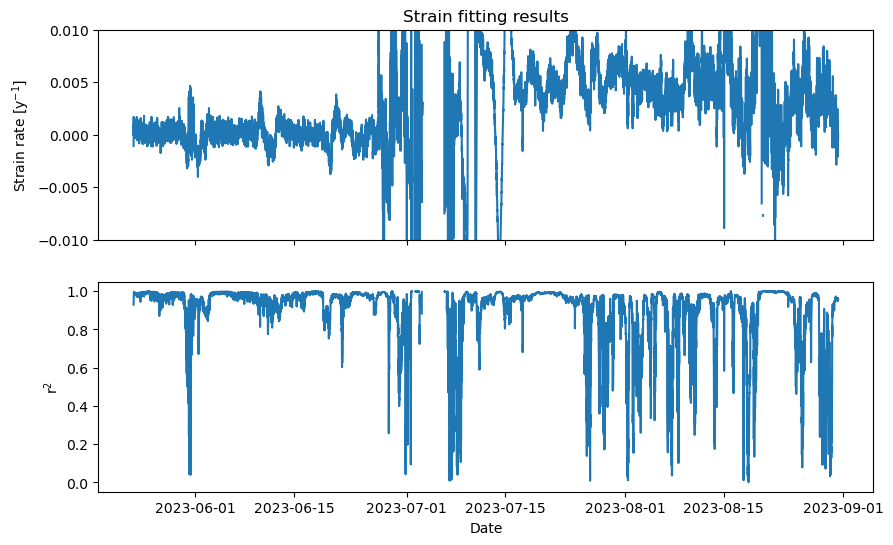

In [116]:
generate_strain_fit(da_104_stacked,40,100)